In [ ]:
# Import all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import itertools

%matplotlib inline

In [ ]:
# Read data from the CSV into a dataframe

file_location1 = '/EPL-18_19.csv'
file_location2 = '/EPL-19_20.csv'
file_location3 = '/EPL-20_21.csv'


raw_data_1 = pd.read_csv(file_location1)
raw_data_2 = pd.read_csv(file_location2)
raw_data_3 = pd.read_csv(file_location3)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cleaning & Sorting Data:

In [ ]:
# Parse data as time 

def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%d-%m-%y').date()
    

  


#Gets all the statistics related to gameplay
                      
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HS','AS',
               'HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']

playing_statistics_1 = raw_data_1[columns_req]                      
playing_statistics_2 = raw_data_2[columns_req]
playing_statistics_3 = raw_data_3[columns_req]


# Concatonating playing statistics

playing_statistics = pd.concat([playing_statistics_1, playing_statistics_2, playing_statistics_3])

# 1) Chances of winning/losing/ drawing for Home as well as Away side:

(a) How many matches have been won/drawn by home teams as well as away team in different seasons?

Text(0.5,0,'Season')

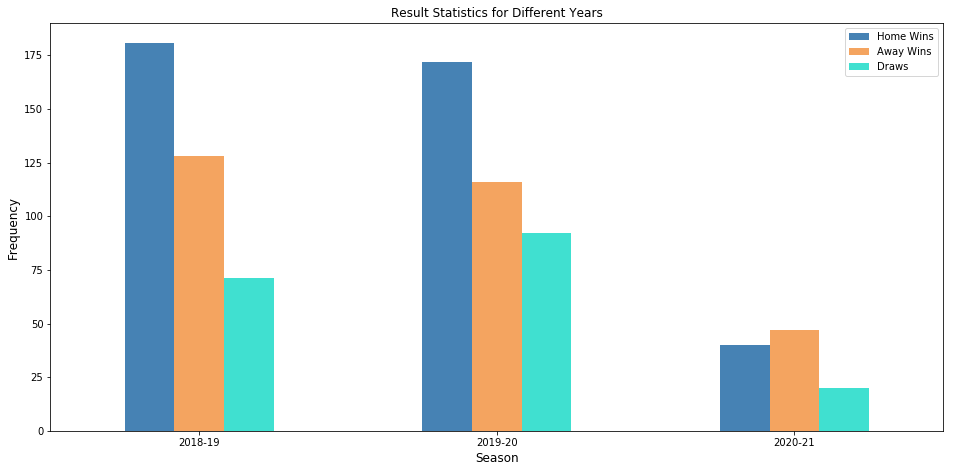

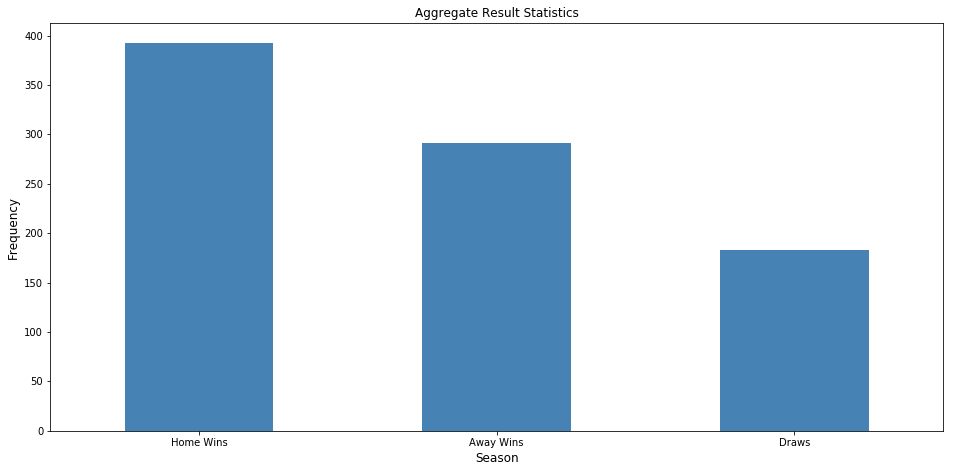

In [ ]:
def get_result_stats(playing_stats, year):
    return pd.DataFrame(data = [ len(playing_stats[playing_stats.FTR == 'H']),
                                 len(playing_stats[playing_stats.FTR == 'A']),
                                 len(playing_stats[playing_stats.FTR == 'D'])],
                        index = ['Home Wins', 'Away Wins', 'Draws'],
                        columns =[year]
                       ).T

result_stats_agg = get_result_stats(playing_statistics, 'Overall')
result_stats_1 = get_result_stats(playing_statistics_1, '2018-19')
result_stats_2 = get_result_stats(playing_statistics_2, '2019-20')
result_stats_3 = get_result_stats(playing_statistics_3, '2020-21')


result_stats = pd.concat([result_stats_1, result_stats_2, result_stats_3])

#Plotting the result dataframe
ax = result_stats.plot(kind='bar', color = ['steelblue','sandybrown', 'turquoise'], figsize = [16,7.5], 
                       title='Result Statistics for Different Years')
plt.xticks(rotation=0)
ax.set_ylabel('Frequency', size=12)
ax.set_xlabel('Season', size=12)

#Plotting agg result dataframe
ax1 = result_stats_agg.T.plot(kind='bar', color = ['steelblue','sandybrown', 'turquoise'], figsize = [16,7.5], 
                       title='Aggregate Result Statistics', legend = False)
plt.xticks(rotation=0)
ax1.set_ylabel('Frequency', size=12)
ax1.set_xlabel('Season', size=12)

In [ ]:
result_stats

Home Wins  Away Wins  Draws
2018-19        181        128     71
2019-20        172        116     92
2020-21         40         47     20

In [ ]:
result_stats_agg

Home Wins  Away Wins  Draws
Overall        393        291    183

(b) What has been the win percentage for Home teams and Away teams?

In [ ]:
result_prop = result_stats.T

for column in result_prop.columns:
    result_prop[column] = (result_prop[column] * 100) / 380  #No. of total matches in a year

# Renames columns
result_prop.rename(index={'Home Wins':'Home', 'Away Wins':'Away', 'Draws':'Draw'}, inplace=True)

# Print df
result_prop

2018-19    2019-20    2020-21
Home  47.631579  45.263158  10.526316
Away  33.684211  30.526316  12.368421
Draw  18.684211  24.210526   5.263158

([<matplotlib.axis.XTick at 0x7fe61cc1b690>,
 <a list of 3 Text xticklabel objects>)

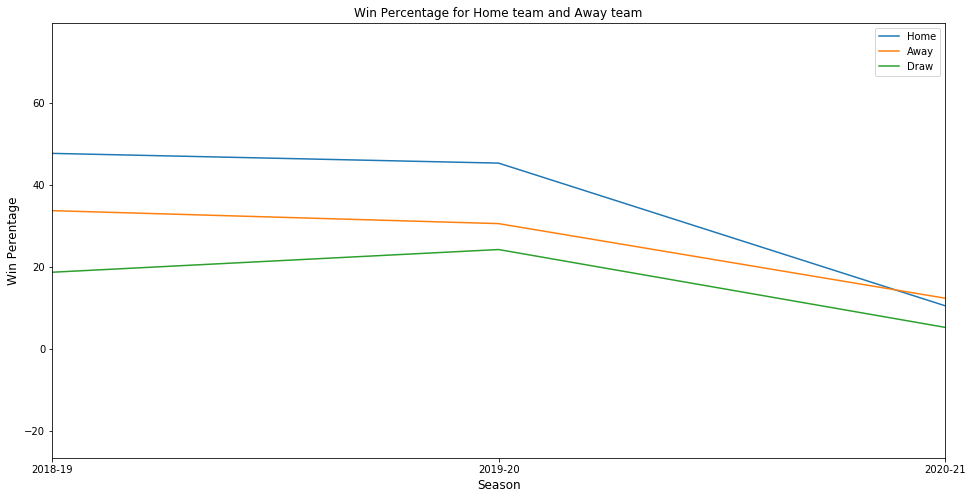

In [ ]:
# Plots a line plot of the win percentages for different parameters in different seasons.

ax = result_prop.T.plot(figsize = [16,8], title = 'Win Percentage for Home team and Away team')
ax.margins(y=.75)
ax.set_xlabel('Season', size =12)
ax.set_ylabel('Win Perentage', size =12)
plt.xticks( np.arange(3), ( '2018-19', '2019-20', '2020-21') )

Win Percentage
Home       34.473684
Away       25.526316
Draw       16.052632

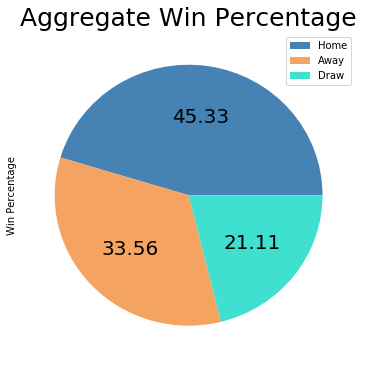

In [ ]:
# Calculating average win percentage for each side:
result_avg_prop = pd.DataFrame((
                                result_prop['2018-19'] + result_prop['2019-20'] + result_prop['2020-21']) / 3, 
                                columns = ['Win Percentage'])

# Plots average win percentage as a pie chart.
ax = result_avg_prop.plot(kind='pie', figsize =[6,6],autopct='%.2f', y='Win Percentage', fontsize =20, labels = None,
                          legend = True, colors = ['steelblue','sandybrown', 'turquoise'])
ax.set_title('Aggregate Win Percentage', size=25)
result_avg_prop

In [ ]:
# Calculating the deviation for each season
avg_home = result_avg_prop['Win Percentage'].loc['Home']
avg_away = result_avg_prop['Win Percentage'].loc['Away']
avg_draw = result_avg_prop['Win Percentage'].loc['Draw']

result_dev = pd.concat([pd.DataFrame(result_prop.loc['Home'] - avg_home).T,
                        pd.DataFrame(result_prop.loc['Away'] - avg_away).T,
                        pd.DataFrame(result_prop.loc['Draw'] - avg_draw).T])


# Calculates the standard deviation 
result_dev['Standard Deviation'] = result_dev.std(axis = 1)
result_dev

2018-19    2019-20    2020-21  Standard Deviation
Home  13.157895  10.789474 -23.947368           20.772811
Away   8.157895   5.000000 -13.157895           11.503944
Draw   2.631579   8.157895 -10.789474            9.743952

# 2) Affect of past 5 games form on odds:

In [ ]:
def get_match_results(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')
            
    return pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
        
matchres_1 = get_match_results(playing_statistics_1)
matchres_2 = get_match_results(playing_statistics_2)



matchres_list = [matchres_1, matchres_2]

In [ ]:
# Gets the location of each fixture as a list for each team in a given season.

def get_match_loc(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location
    for i in range(len(playing_stat)):
        teams[playing_stat.iloc[i].HomeTeam].append('H')
        teams[playing_stat.iloc[i].AwayTeam].append('A')
        
    return pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T

# Get match location for each team and for each season.

match_loc_1 = get_match_loc(playing_statistics_1)
match_loc_2 = get_match_loc(playing_statistics_2)


match_loc_list = [match_loc_1, match_loc_2]

In [ ]:
def get_past_form(form_list,match_loc_list, size):
    perm_dict = {}
    for i in range(len(form_list)):
        df = form_list[i].T
        m_df = match_loc_list[i].T
        
        for team in df.columns:
            i = 0
            while i != (38-size):
                n = 0 
                comb = ''
                while n < size:
                    comb = comb + df[team].iloc[i+n]
                    n+=1
                result = df[team].iloc[i+size]
                side = m_df[team].iloc[i+size]
                if comb in perm_dict:
                    perm_dict[comb].append([result,side])
                else:
                    perm_dict[comb] = []
                    perm_dict[comb].append([result,side])
                i = i+1
                
    return perm_dict
        
past_form_comb_5 = get_past_form(matchres_list, match_loc_list, 5)
past_form_comb_3 = get_past_form(matchres_list, match_loc_list, 3)

In [ ]:
# Calculates wins/losses/draws for home/away side

def get_form_stats(past_form_c):
    past_form_res = {}
    for key in past_form_c.keys():
        total = len(past_form_c[key])
        HW = 0
        HL = 0
        AW = 0 
        AL = 0
        HD = 0
        AD = 0
        for result,loc in past_form_c[key]:
            if loc == 'H':
                if result == 'W':
                    HW += 1 
                elif result == 'L':
                    HL += 1
                else:
                    HD += 1
            else:
                if result == 'W':
                    AW += 1 
                elif result == 'L':
                    AL += 1
                else:
                    AD += 1
        past_form_res[key] = [HW, HL, HD, AW, AL, AD, HW+AW, HL+AL, HD+AD, total]

    past_form_prob = pd.DataFrame(past_form_res).T

    # Change column names to correct ones
    past_form_prob = pd.DataFrame(past_form_res).T
    past_form_prob.rename(columns = {0:'HomeWin', 1:'HomeLoss', 2:'HomeDraw', 3:'AwayWin', 4:'AwayLoss', 5:'AwayDraw',
                                     6:'TotalWins', 7:'TotalLosses', 8:'TotalDraws', 9:'TotalMatches' }, inplace=True)

    # Convert the numbers to probability
    for col in ['HomeWin', 'HomeLoss', 'HomeDraw', 'AwayWin', 'AwayLoss', 'AwayDraw', 'TotalWins', 'TotalLosses', 'TotalDraws']:
        past_form_prob[col] = past_form_prob[col] / past_form_prob['TotalMatches']
    
    # Change column names again
    past_form_prob.rename(columns = {'HomeWin':'P(W/H)', 'HomeLoss': 'P(L/H)', 'HomeDraw': 'P(D/H)', 'AwayWin': 'P(W/A)',
                                     'AwayLoss': 'P(L/A)','AwayDraw': 'P(D/A)','TotalWins': 'P(W)', 'TotalLosses': 'P(L)',
                                     'TotalDraws': 'P(D)'}, inplace=True)
    return past_form_prob 

past_form_prob_5 = get_form_stats(past_form_comb_5)
past_form_prob_3 = get_form_stats(past_form_comb_3)

In [ ]:
past_form_prob_3.sort('P(D)', ascending=False)

AttributeError: ignored

# 3) How is the difference in points related to the result of the match:

In [ ]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

def get_cuml_points(matchres):
    matchres_points = matchres.applymap(get_points)
    for i in range(2,39):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]
        
    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(20)])
    return matchres_points

cuml_pts_1 = get_cuml_points(matchres_1)
cuml_pts_2 = get_cuml_points(matchres_2)


cuml_pts_1.head()

0   1   2   3   4   5   6   7   8   9   ...  29  30  31  32  33  \
Arsenal       0   0   0   3   6   9  12  15  18  21  ...  57  60  63  63  66   
Bournemouth   0   3   6   7   7  10  10  13  16  17  ...  34  37  38  38  38   
Brighton      0   0   3   3   4   5   5   5   8  11  ...  33  33  33  33  33   
Burnley       0   1   1   1   1   1   4   7   8   8  ...  30  30  30  33  36   
Cardiff       0   0   1   2   2   2   2   2   2   5  ...  25  28  28  28  28   

             34  35  36  37  38  
Arsenal      66  66  66  67  70  
Bournemouth  41  41  42  45  45  
Brighton     34  34  35  36  36  
Burnley      39  40  40  40  40  
Cardiff      31  31  31  31  34  

[5 rows x 39 columns]

In [ ]:
# (2) Gets the difference between the points of any two teams in any matchweek.
def get_diff(ht,at,week,cuml_pts):
    ht_pts = cuml_pts[week-1].loc[ht]
    at_pts = cuml_pts[week-1].loc[at]
    diff = ht_pts - at_pts
    return diff

def points_diff(playing_stat, cuml_pts):
    point_diff_overall = {}
    matches = 0
    for week in range(1,39):
        point_diff = []
        for match in range(matches,matches+10):
            ht = playing_stat.iloc[match].HomeTeam
            at = playing_stat.iloc[match].AwayTeam
            res = playing_stat.iloc[match].FTR
            diff = get_diff(ht,at,week,cuml_pts)
            
            if res == 'H':
                point_diff.append([diff, 'HW'])
            elif res == 'A':
                point_diff.append([diff, 'AW'])
            else:
                point_diff.append([diff, 'D'])
        point_diff_overall[week] = point_diff
        matches += 10
    return point_diff_overall
                
points_diff_1 = points_diff(playing_statistics_1, cuml_pts_1)
points_diff_2 = points_diff(playing_statistics_2, cuml_pts_2)

points_diff_list = [points_diff_1, points_diff_2]

def merge_dicts(dicts_to_merge):
    # Creates a merged dictionary with keys as that of the dictionaries to merge and values as an empty list
    merged_dict = {}
    for key in dicts_to_merge[0].keys():
        merged_dict[key] = []
        
    for dictionary in dicts_to_merge:
        for key in dictionary.keys():
            merged_dict[key] = merged_dict[key] + dictionary[key]
            
    return merged_dict

points_diff = merge_dicts(points_diff_list)

def make_df(points_diff_dict, key):
    df = pd.DataFrame(points_diff_dict[key], columns = ['Diff', 'Result'])
    df.sort_values(by ='Diff',inplace=True)
    df = df.reset_index(drop=True)                        # resets index 
    return df

# Gets point difference for each matchweek
pd_mw1 = make_df(points_diff,1)
pd_mw2 = make_df(points_diff,2)
pd_mw3 = make_df(points_diff,3)
pd_mw4 = make_df(points_diff,4)
pd_mw5 = make_df(points_diff,5)
pd_mw6 = make_df(points_diff,6)
pd_mw7 = make_df(points_diff,7)
pd_mw8 = make_df(points_diff,8)
pd_mw9 = make_df(points_diff,9)
pd_mw10 = make_df(points_diff,10)
pd_mw11 = make_df(points_diff,11)
pd_mw12 = make_df(points_diff,12)
pd_mw13 = make_df(points_diff,13)
pd_mw14 = make_df(points_diff,14)
pd_mw15 = make_df(points_diff,15)
pd_mw16 = make_df(points_diff,16)
pd_mw17 = make_df(points_diff,17)
pd_mw18 = make_df(points_diff,18)
pd_mw19 = make_df(points_diff,19)
pd_mw20 = make_df(points_diff,20)
pd_mw21 = make_df(points_diff,21)
pd_mw22 = make_df(points_diff,22)
pd_mw23 = make_df(points_diff,23)
pd_mw24 = make_df(points_diff,24)
pd_mw25 = make_df(points_diff,25)
pd_mw26 = make_df(points_diff,26)
pd_mw27 = make_df(points_diff,27)
pd_mw28 = make_df(points_diff,28)
pd_mw29 = make_df(points_diff,29)
pd_mw30 = make_df(points_diff,30)
pd_mw31 = make_df(points_diff,31)
pd_mw32 = make_df(points_diff,32)
pd_mw33 = make_df(points_diff,33)
pd_mw34 = make_df(points_diff,34)
pd_mw35 = make_df(points_diff,35)
pd_mw36 = make_df(points_diff,36)
pd_mw37 = make_df(points_diff,37)
pd_mw38 = make_df(points_diff,38)

def get_freqtab_pd(pd_mw, classes):
    freq_table = {}
    counter = 0
    range_diff = abs(pd_mw.iloc[0].Diff) + abs(pd_mw.iloc[149].Diff)
    class_size = int(range_diff / classes)

    for i in range(pd_mw.iloc[0].Diff, pd_mw.iloc[149].Diff, class_size):
        ll = i
        ul = i + class_size
        freq_table[str(ll) + ' to ' + str(ul)] = []
        
        for i in range(150):
            diff = pd_mw.iloc[i].Diff
            res = pd_mw.iloc[i].Result
            if (diff >= ll) & (diff < ul):
                freq_table[str(ll) + ' to ' + str(ul)].append(res)
                counter += 1
        
    return freq_table, counter

get_freqtab_pd(pd_mw3, 10)




In [ ]:
def get_diff(ht,at,week,cuml_pts):
    ht_pts = cuml_pts[week-1].loc[ht]
    at_pts = cuml_pts[week-1].loc[at]
    diff = ht_pts - at_pts
    return diff

def points_diff(playing_stat, cuml_pts):
    point_diff_overall = {}
    matches = 0
    for week in range(1,39):                       # 38 matchweeks in a season
        point_diff = {}
        for match in range(matches,matches+10):
            ht = playing_stat.iloc[match].HomeTeam
            at = playing_stat.iloc[match].AwayTeam
            res = playing_stat.iloc[match].FTR
            diff = get_diff(ht,at,week,cuml_pts)
            if res == 'H':
                if diff not in point_diff:
                    point_diff[diff] = ['HW']
                else:
                    point_diff[diff].append('HW')
            elif res == 'A':
                if diff not in point_diff:
                    point_diff[diff] = ['AW']
                else:
                    point_diff[diff].append('AW')
            else:
                if diff not in point_diff:
                    point_diff[diff] = ['D']
                else:
                    point_diff[diff].append('D')
        point_diff_overall[week] = point_diff
        matches += 10
    return point_diff_overall
                
points_diff_1 = points_diff(playing_statistics_1, cuml_pts_1)
points_diff_2 = points_diff(playing_statistics_2, cuml_pts_2)
points_diff_3 = points_diff(playing_statistics_3, cuml_pts_3)
points_diff_4 = points_diff(playing_statistics_4, cuml_pts_4)
points_diff_5 = points_diff(playing_statistics_5, cuml_pts_5)
points_diff_6 = points_diff(playing_statistics_6, cuml_pts_6)
points_diff_7 = points_diff(playing_statistics_7, cuml_pts_7)
points_diff_8 = points_diff(playing_statistics_8, cuml_pts_8)
points_diff_9 = points_diff(playing_statistics_9, cuml_pts_9)
points_diff_10 = points_diff(playing_statistics_10, cuml_pts_10)
points_diff_11 = points_diff(playing_statistics_11, cuml_pts_11)
points_diff_12 = points_diff(playing_statistics_12, cuml_pts_12)
points_diff_13 = points_diff(playing_statistics_13, cuml_pts_13)
points_diff_14 = points_diff(playing_statistics_14, cuml_pts_14)
points_diff_15 = points_diff(playing_statistics_15, cuml_pts_15)

points_diff_list = [points_diff_1, points_diff_2, points_diff_3, points_diff_4, points_diff_5, points_diff_6,
                    points_diff_7, points_diff_8, points_diff_9, points_diff_10, points_diff_11, points_diff_12,
                    points_diff_13, points_diff_14, points_diff_15]

In [ ]:
points_diff = {}
for key in range(1,39):
    points_diff[key] = {}
    
def merge_dicts(target_dict, dicts_to_merge):
    for points_diff_n in dicts_to_merge:
        for mw in [i for i in range(1,39)]:
            differences = points_diff_n[mw].keys()
            for diff in differences:
                if diff in points_diff[mw]:
                    points_diff[mw][diff] = points_diff[mw][diff] + points_diff_n[mw][diff]
                else:
                    points_diff[mw][diff] = points_diff_n[mw][diff]
    return target_dict

points_diff = merge_dicts(points_diff, points_diff_list)

In [ ]:
mw_dist = {}

for mw in points_diff.keys():
    differences = {}
    for diff in points_diff[mw].keys():
        homewins = 0
        awaywins = 0
        draws = 0
        results = [0,0,0]
        
        for result in points_diff[mw][diff]:
            matches = len(points_diff[mw][diff])
            if result == 'HW':
                homewins += 1
            elif result == 'AW':
                awaywins += 1
            else:
                draws += 1
        
        differences[diff] = [homewins, awaywins, draws]
    mw_dist[mw] = differences
        




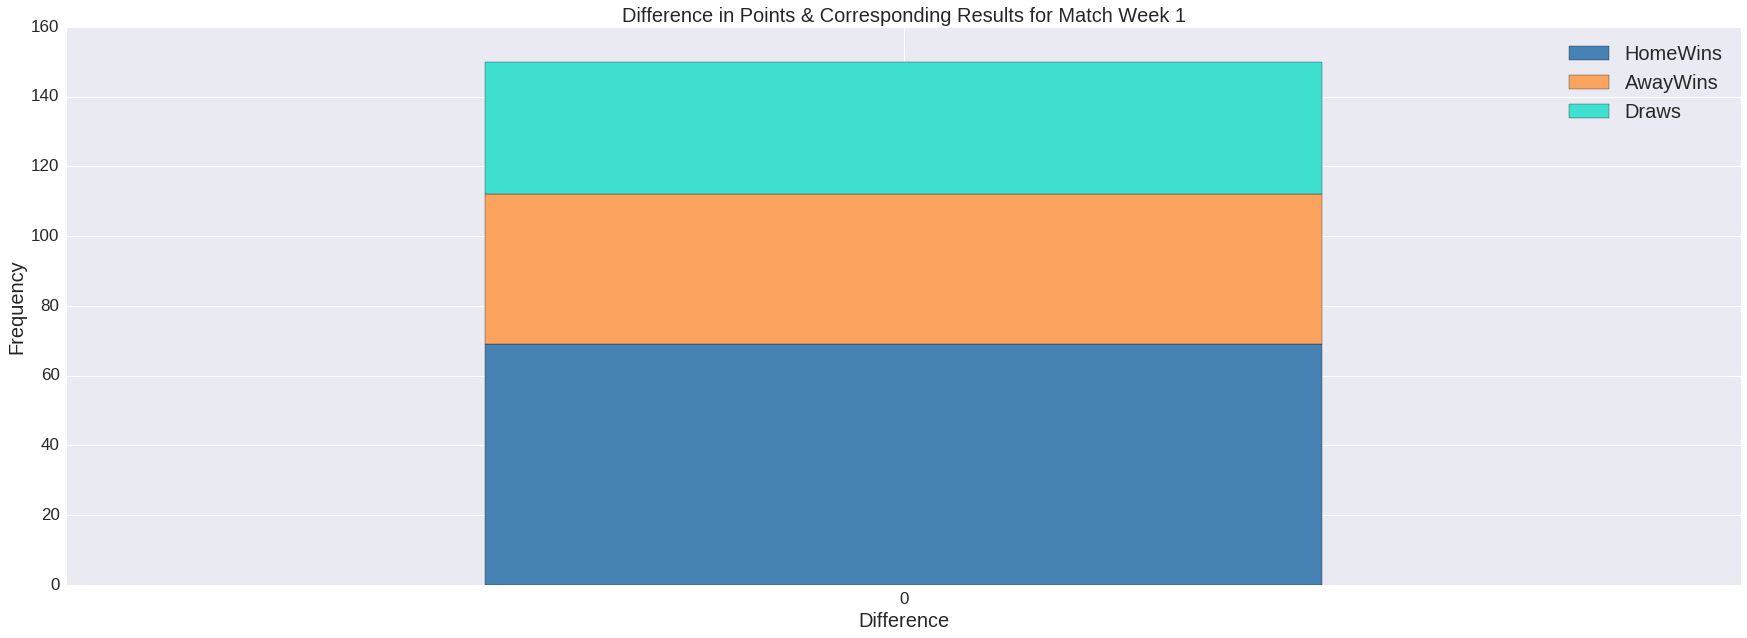

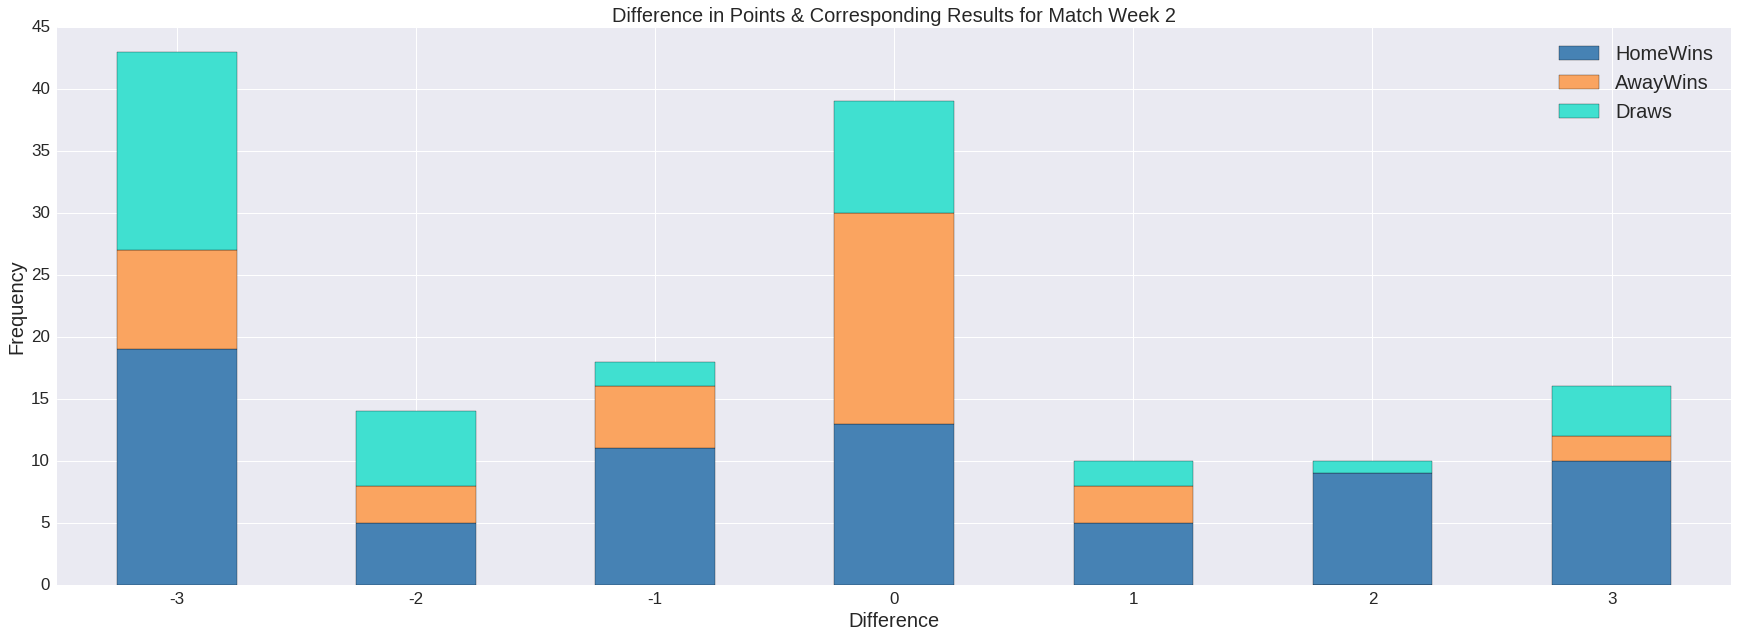

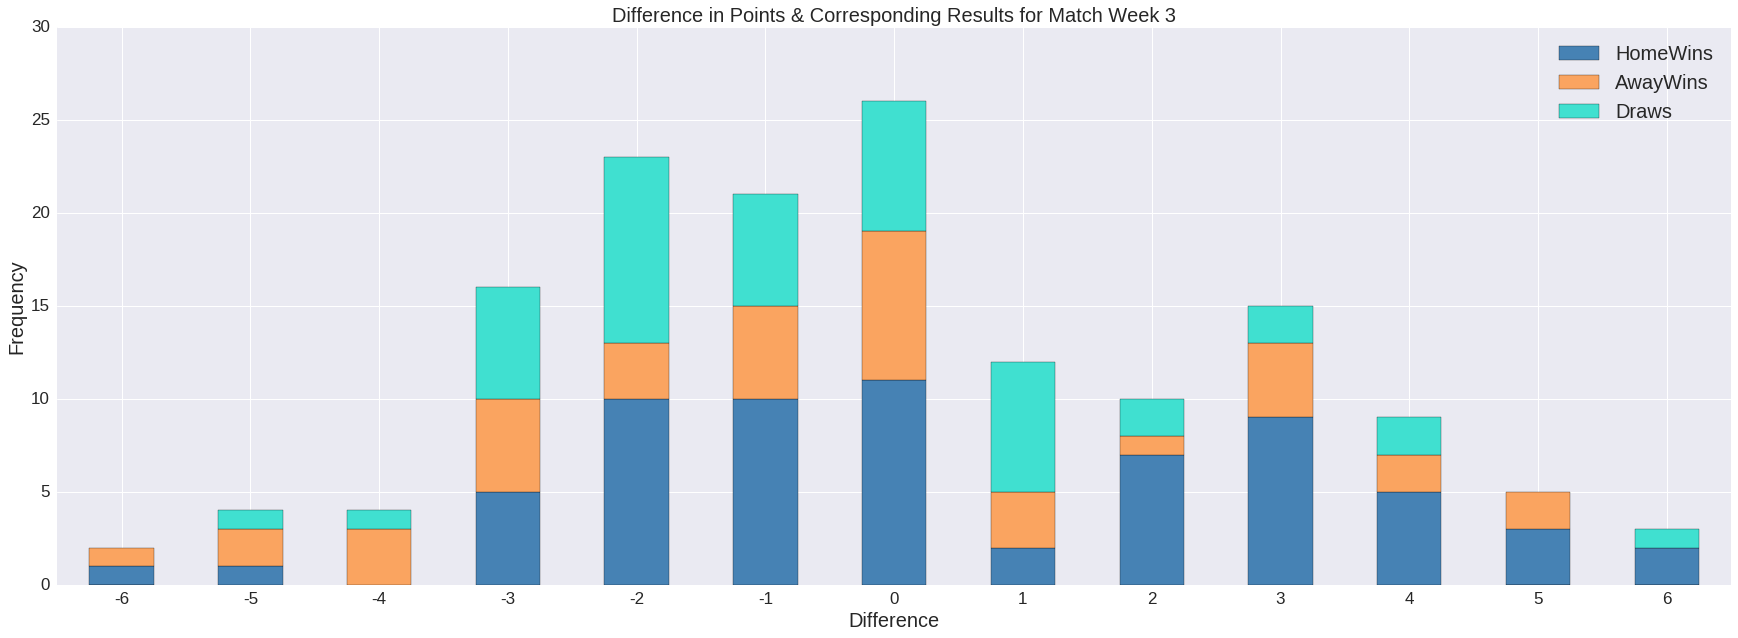

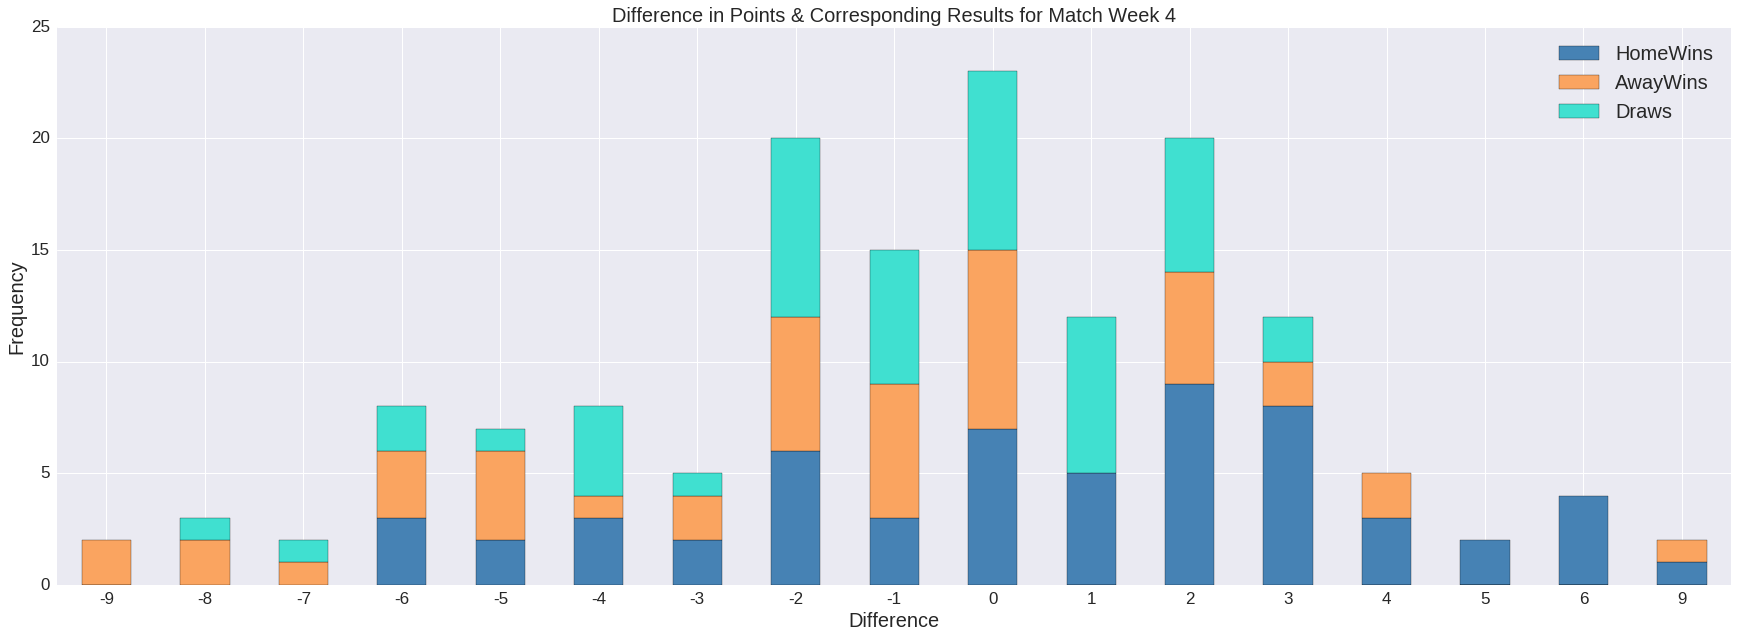

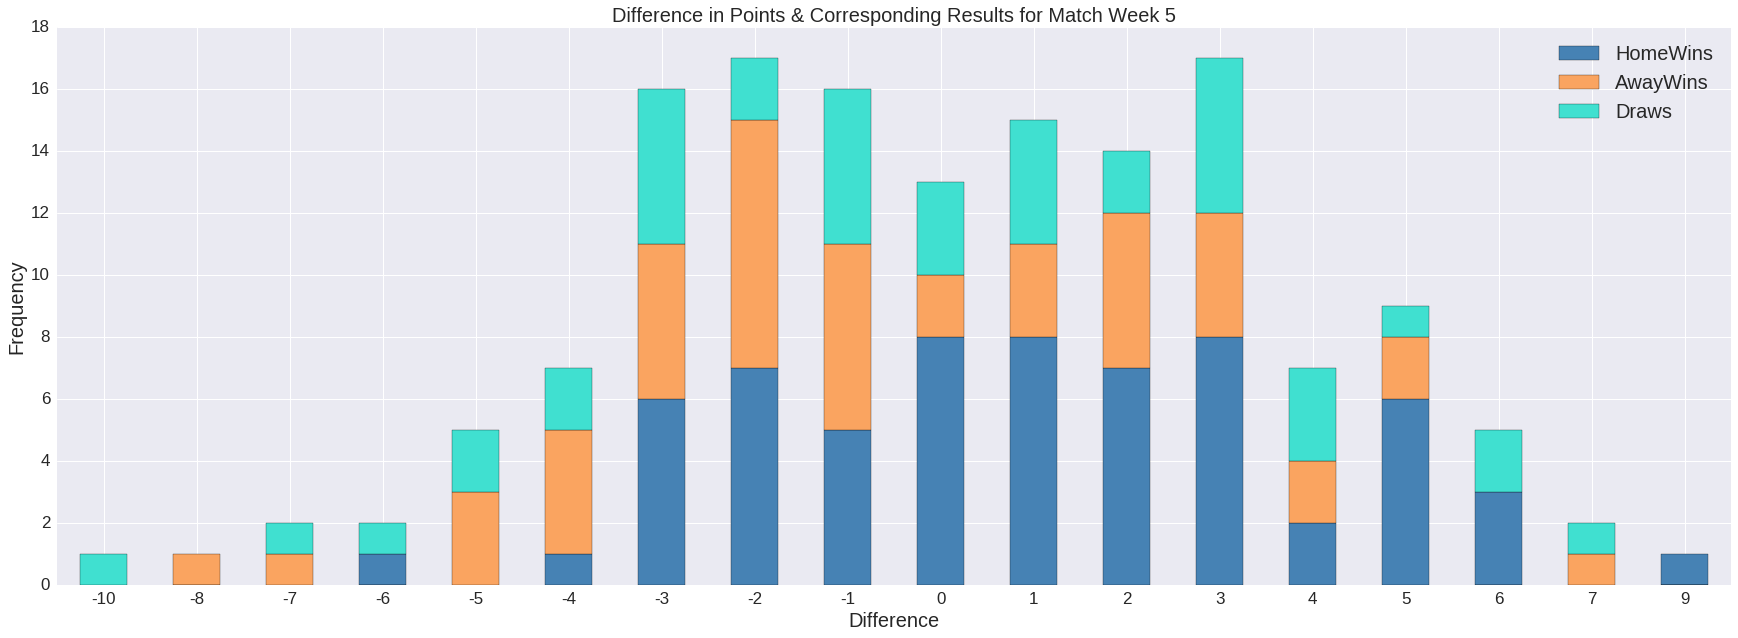

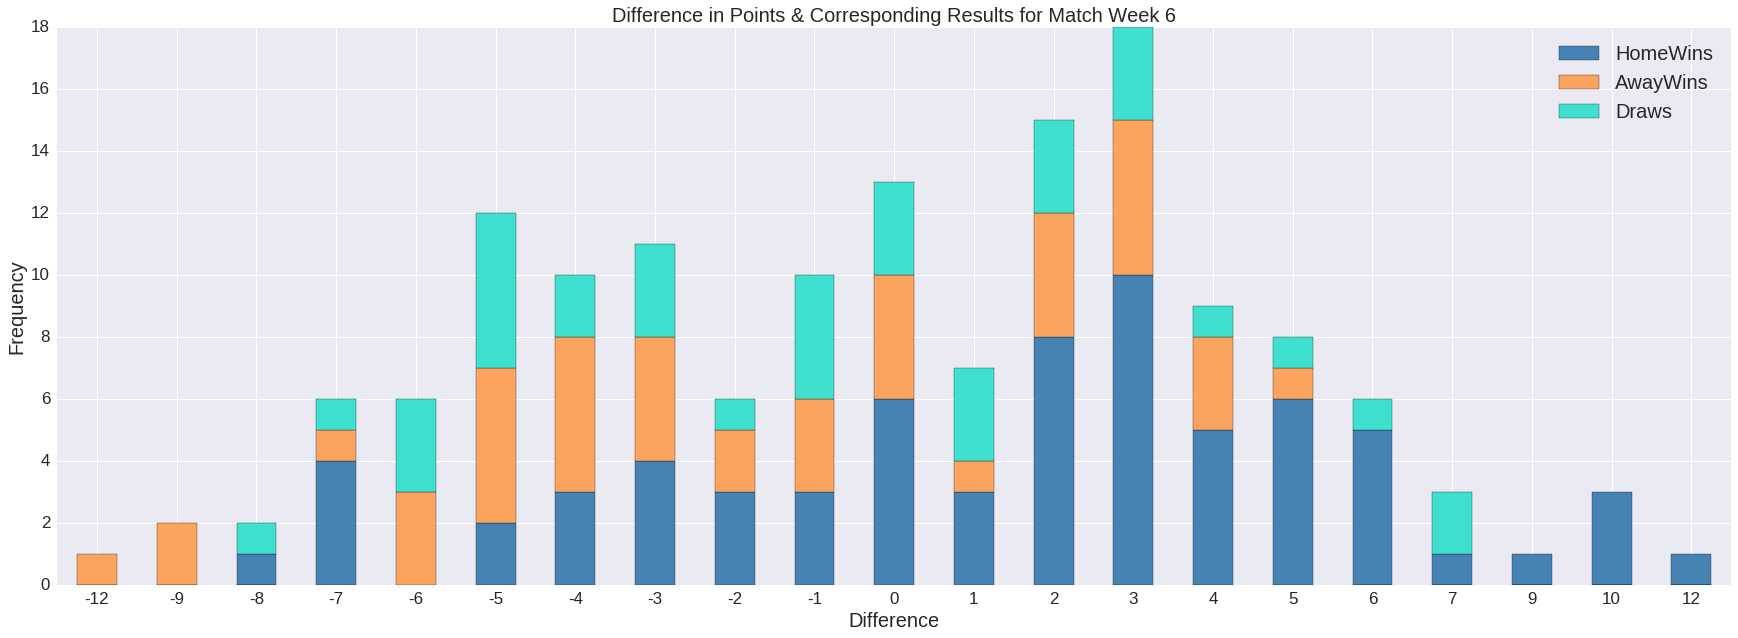

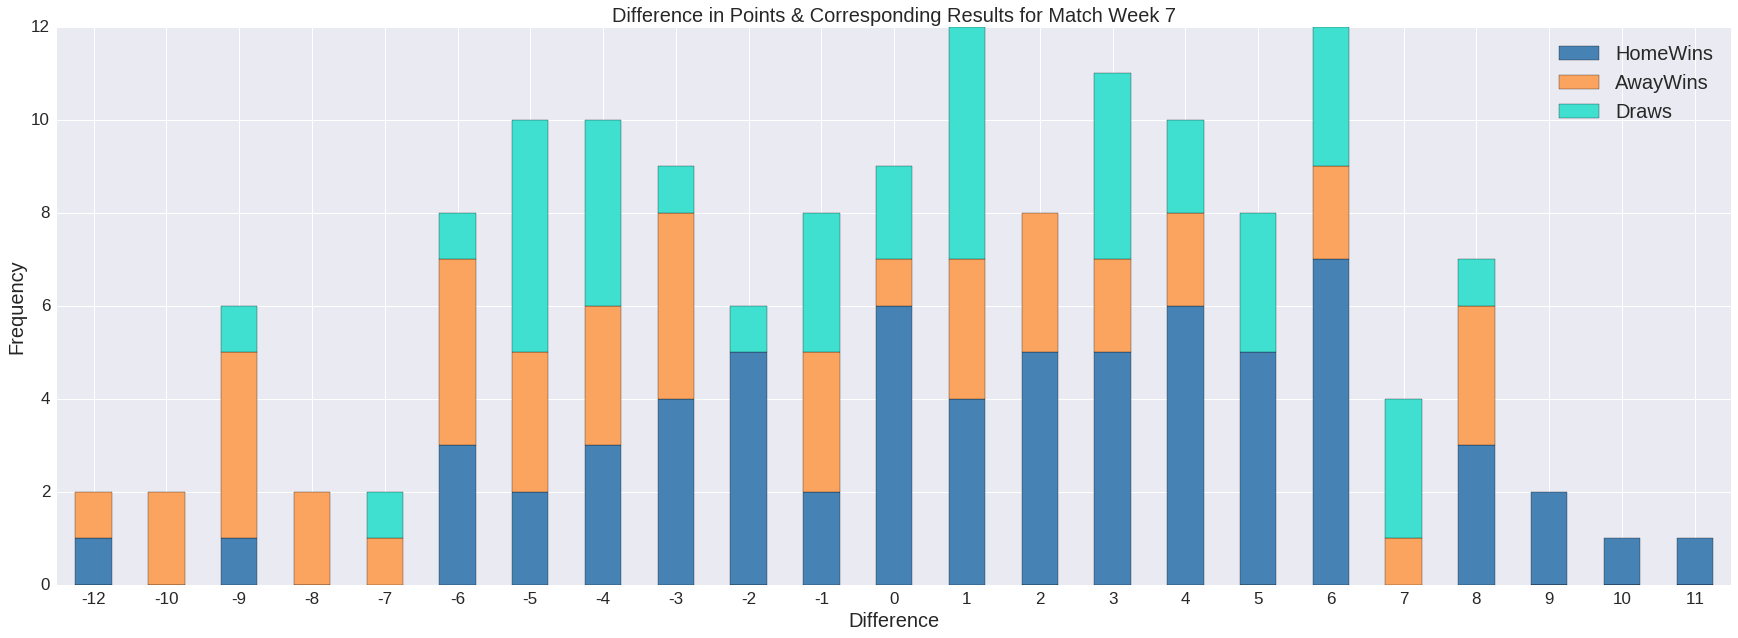

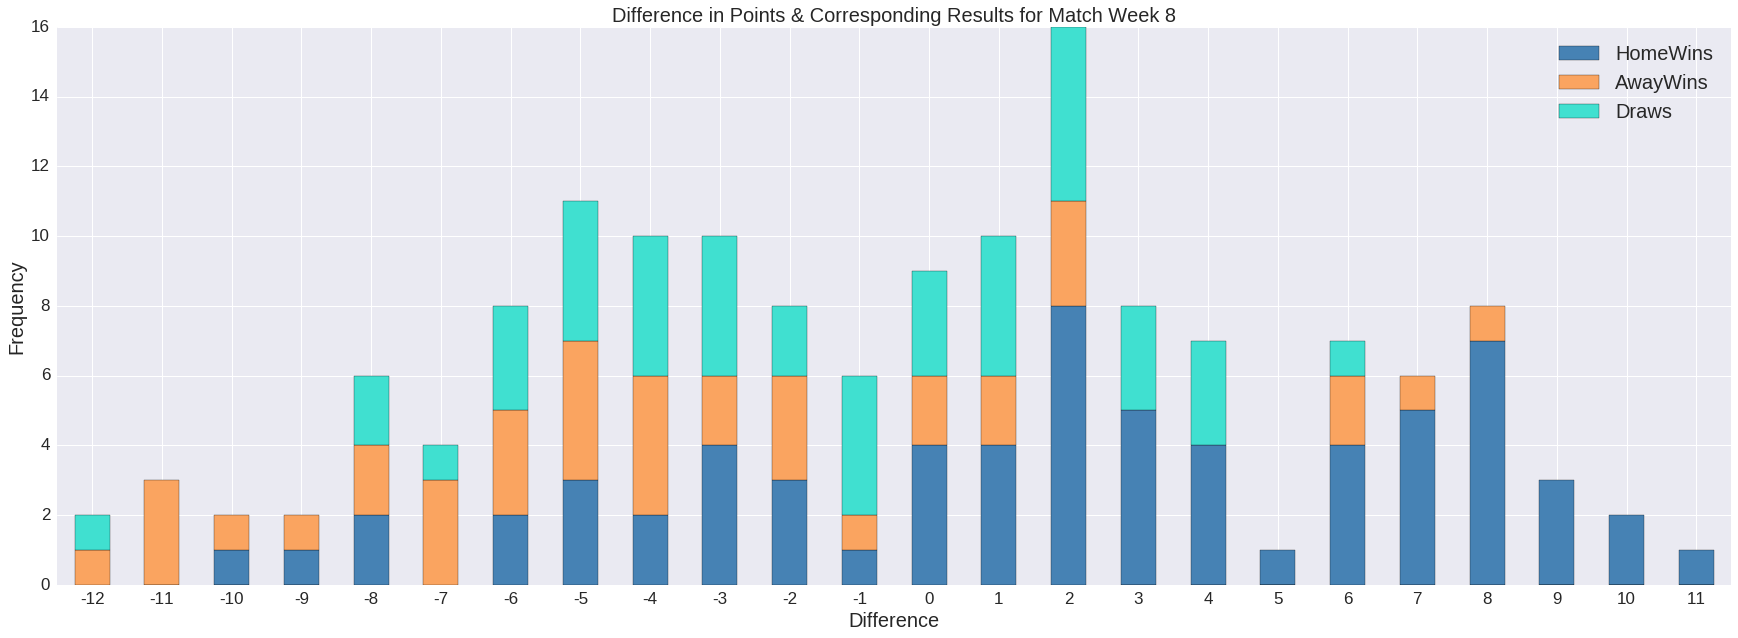

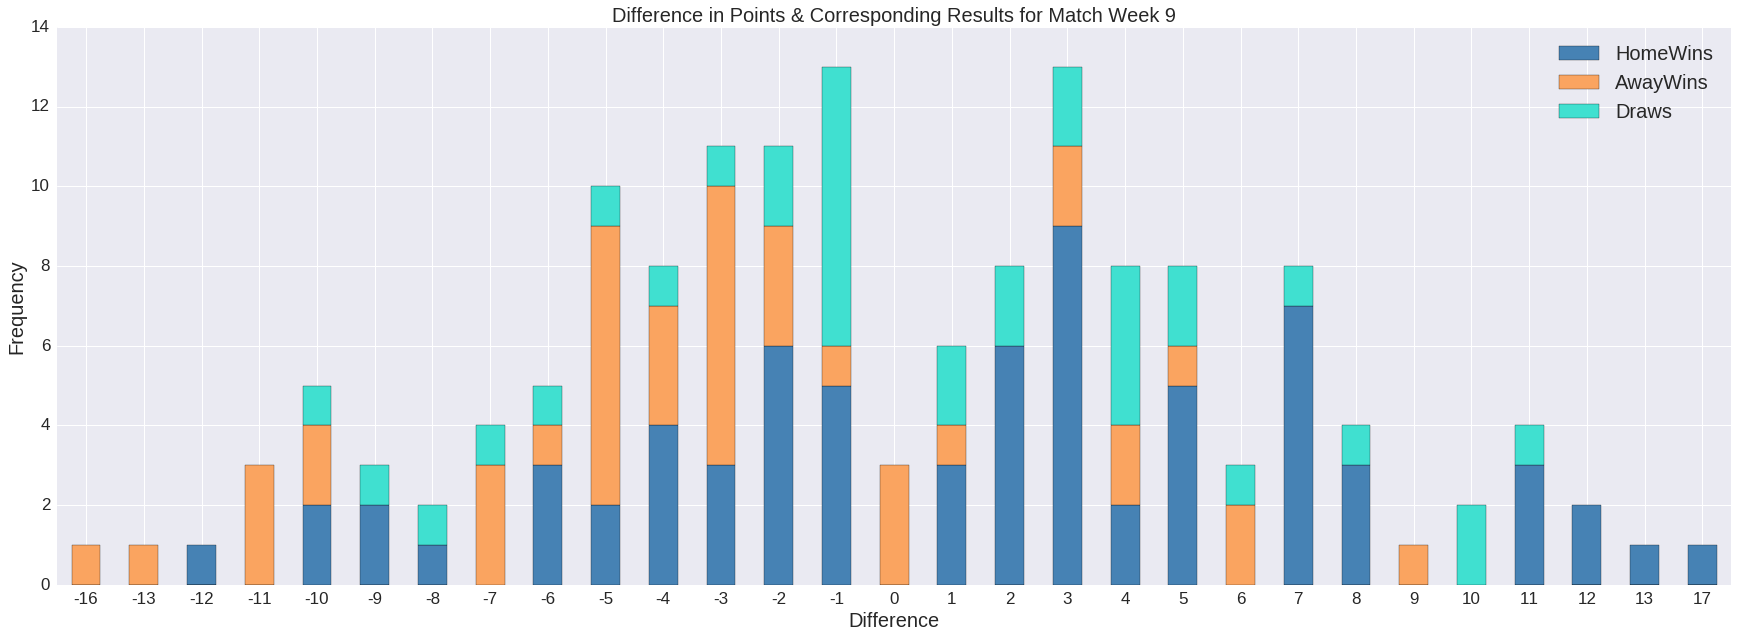

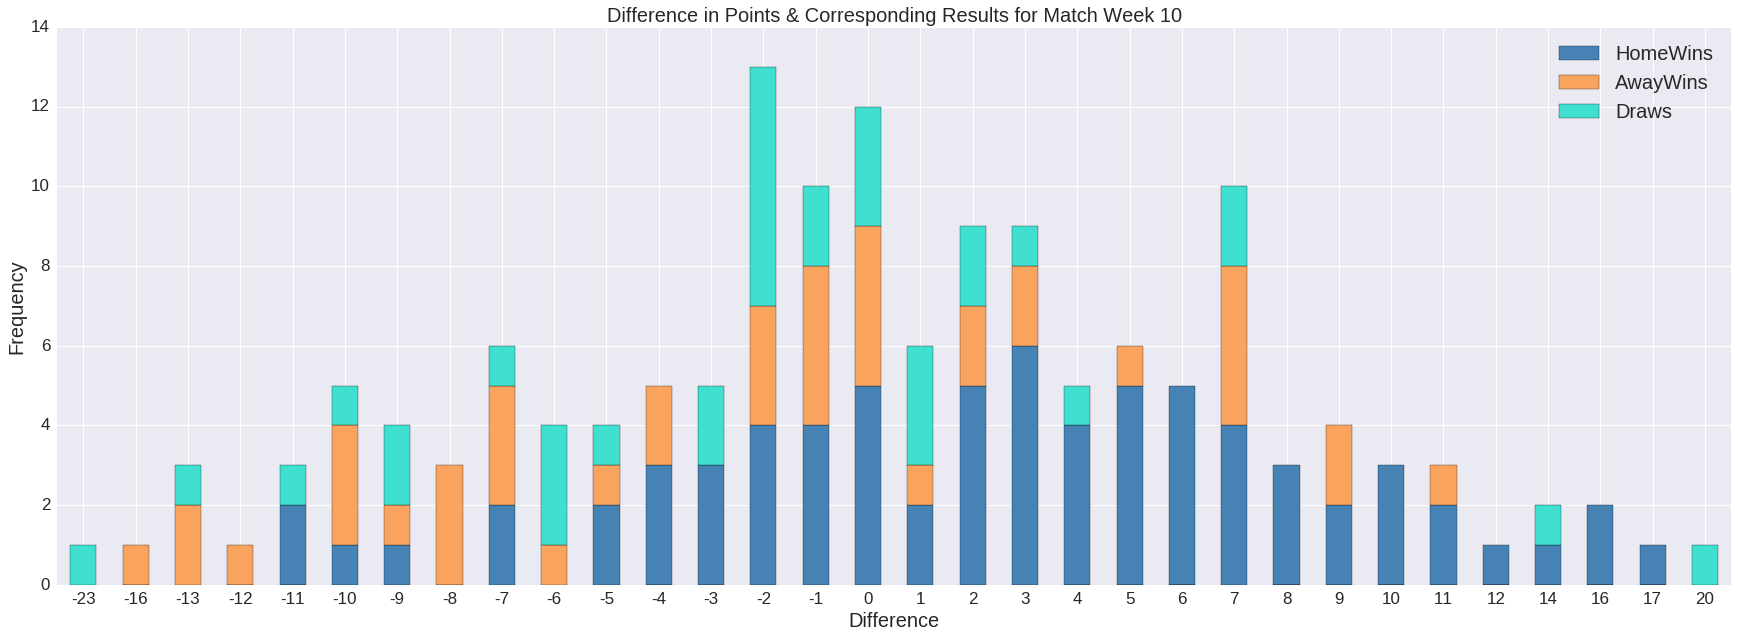

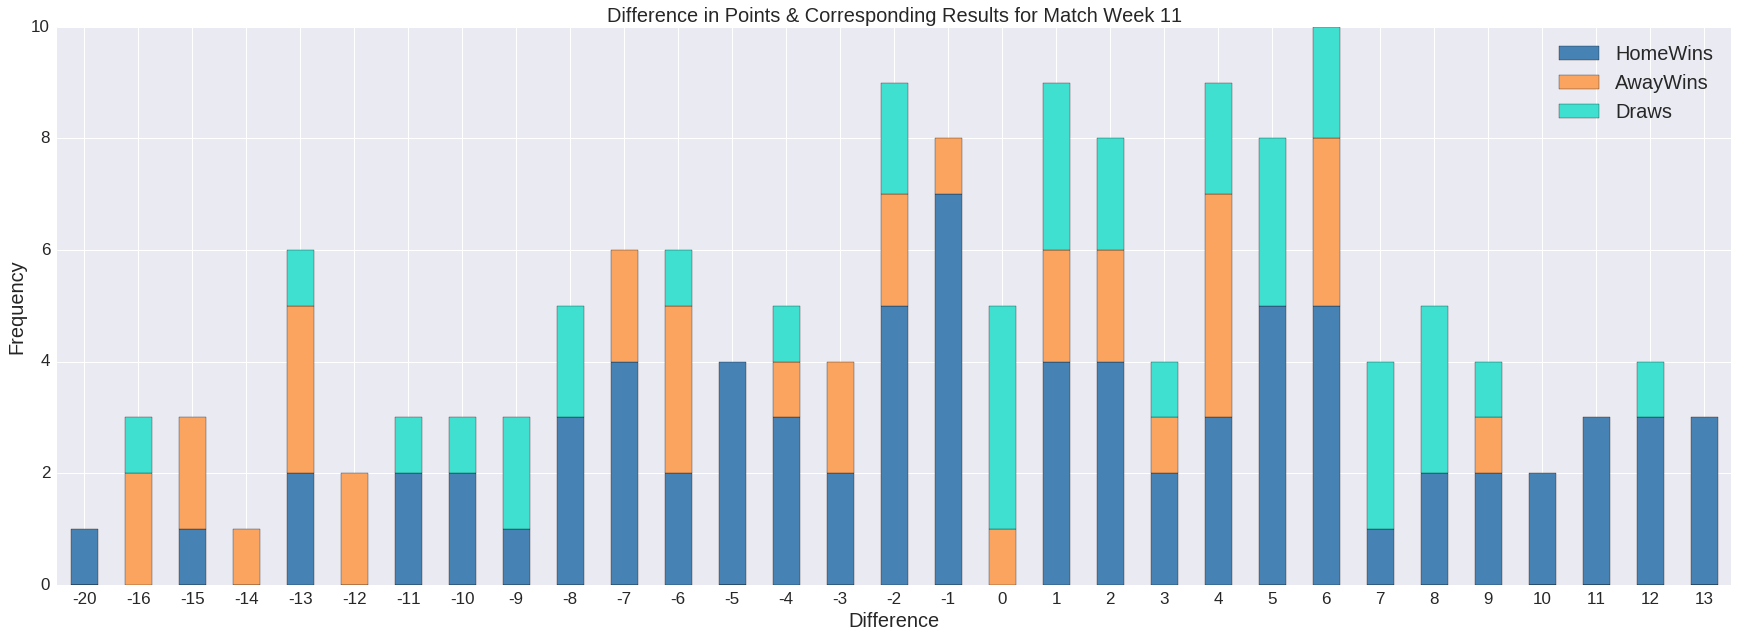

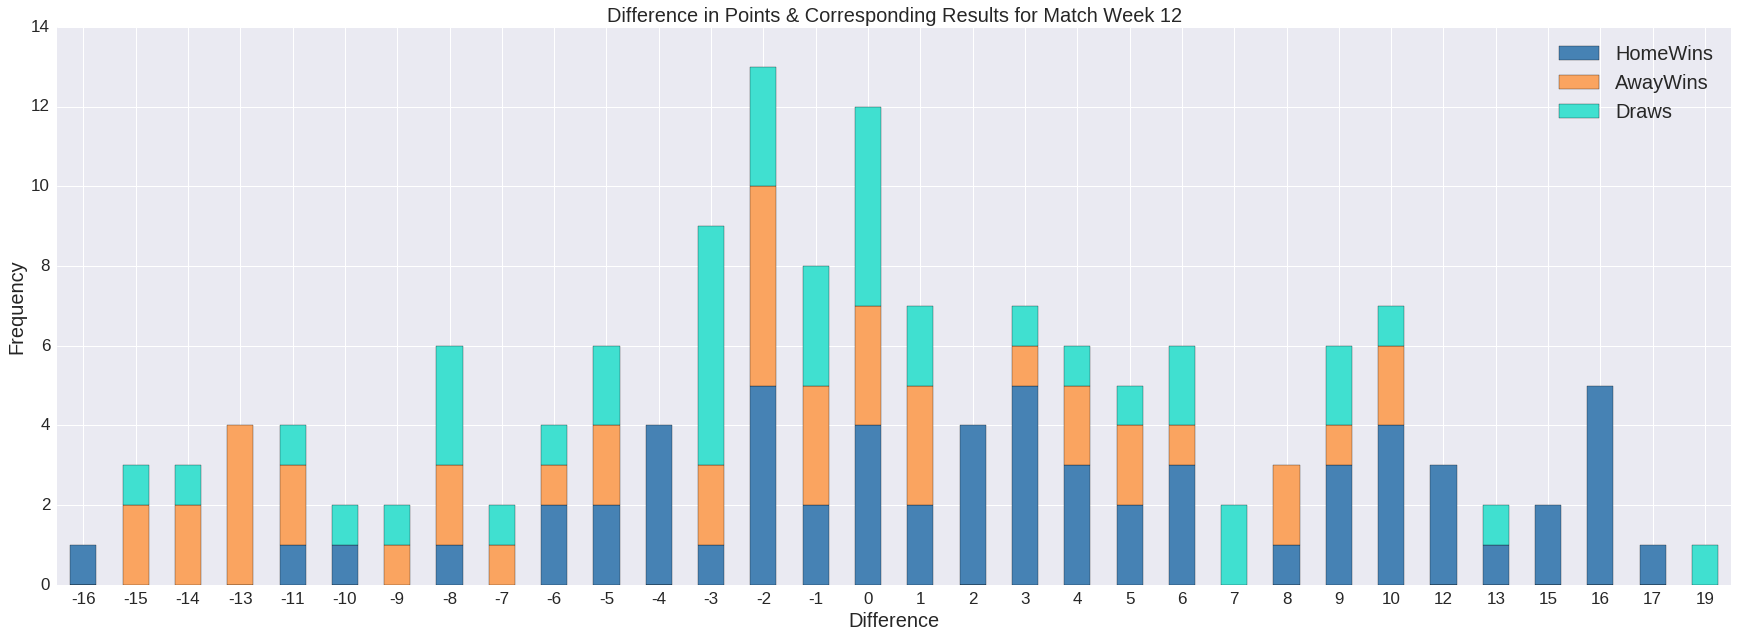

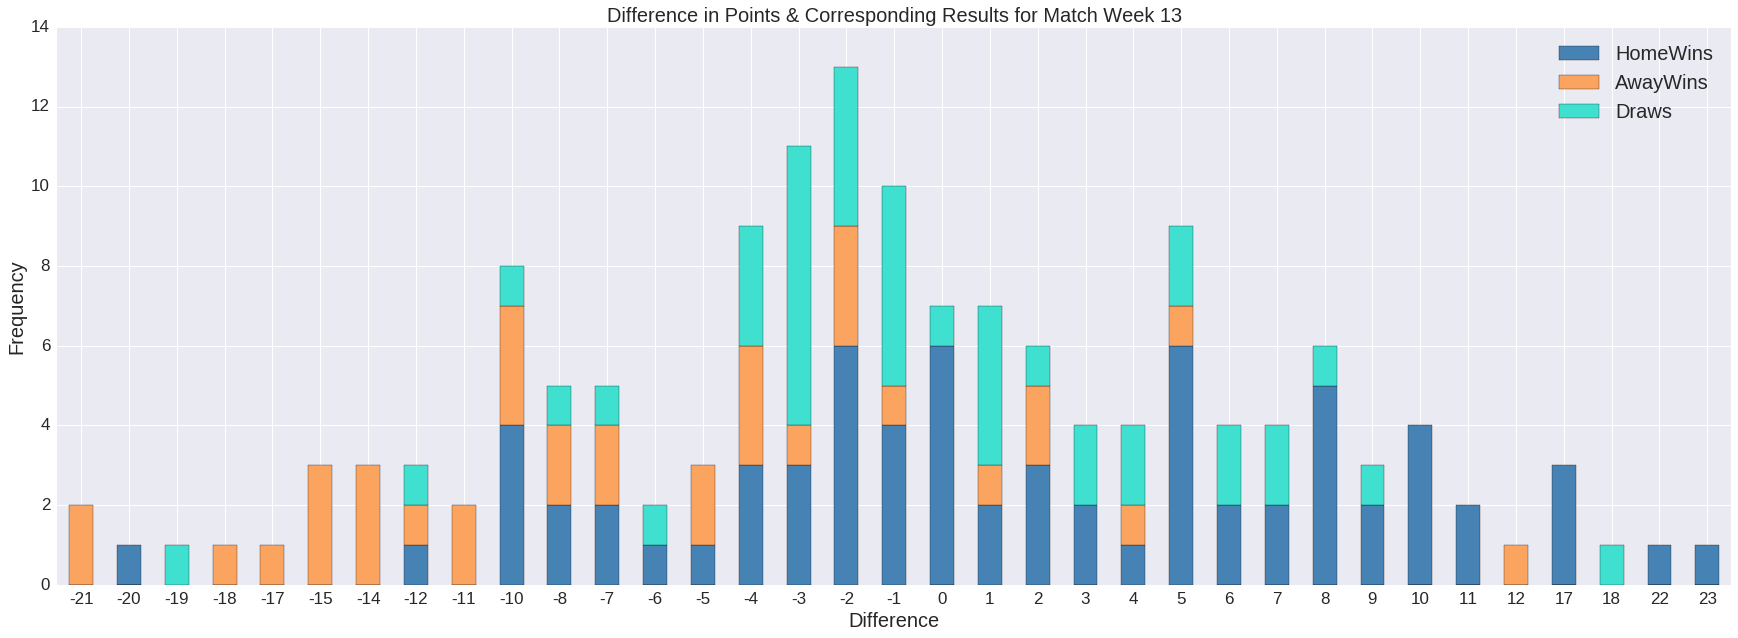

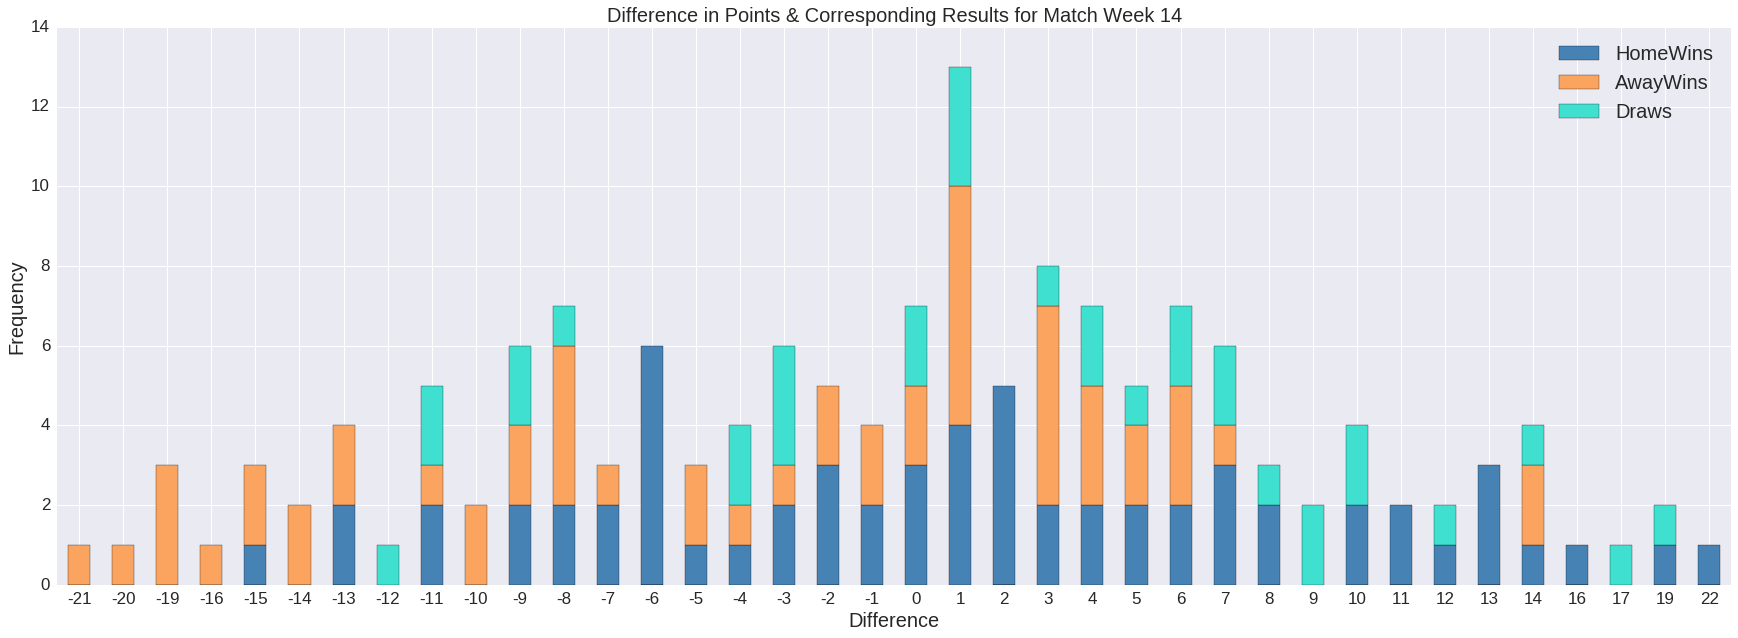

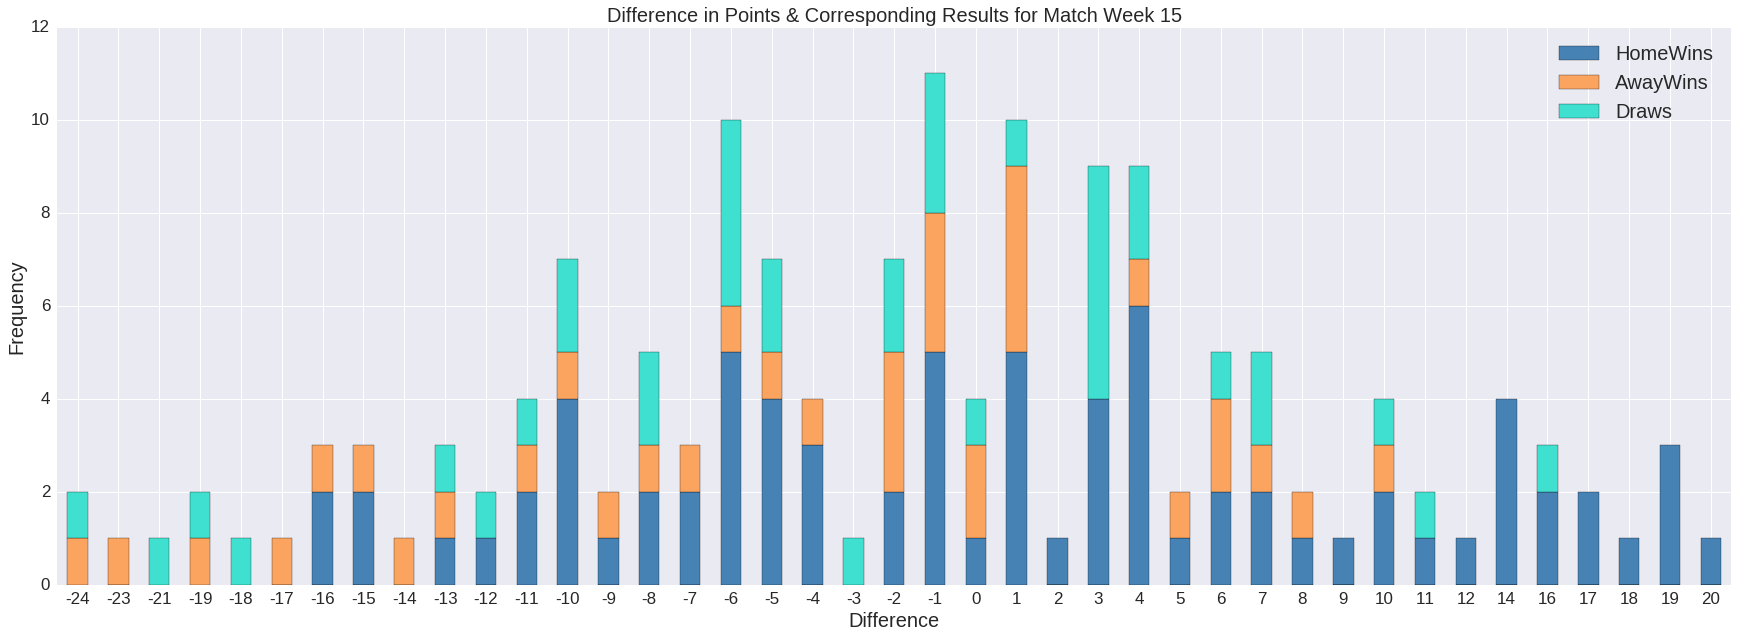

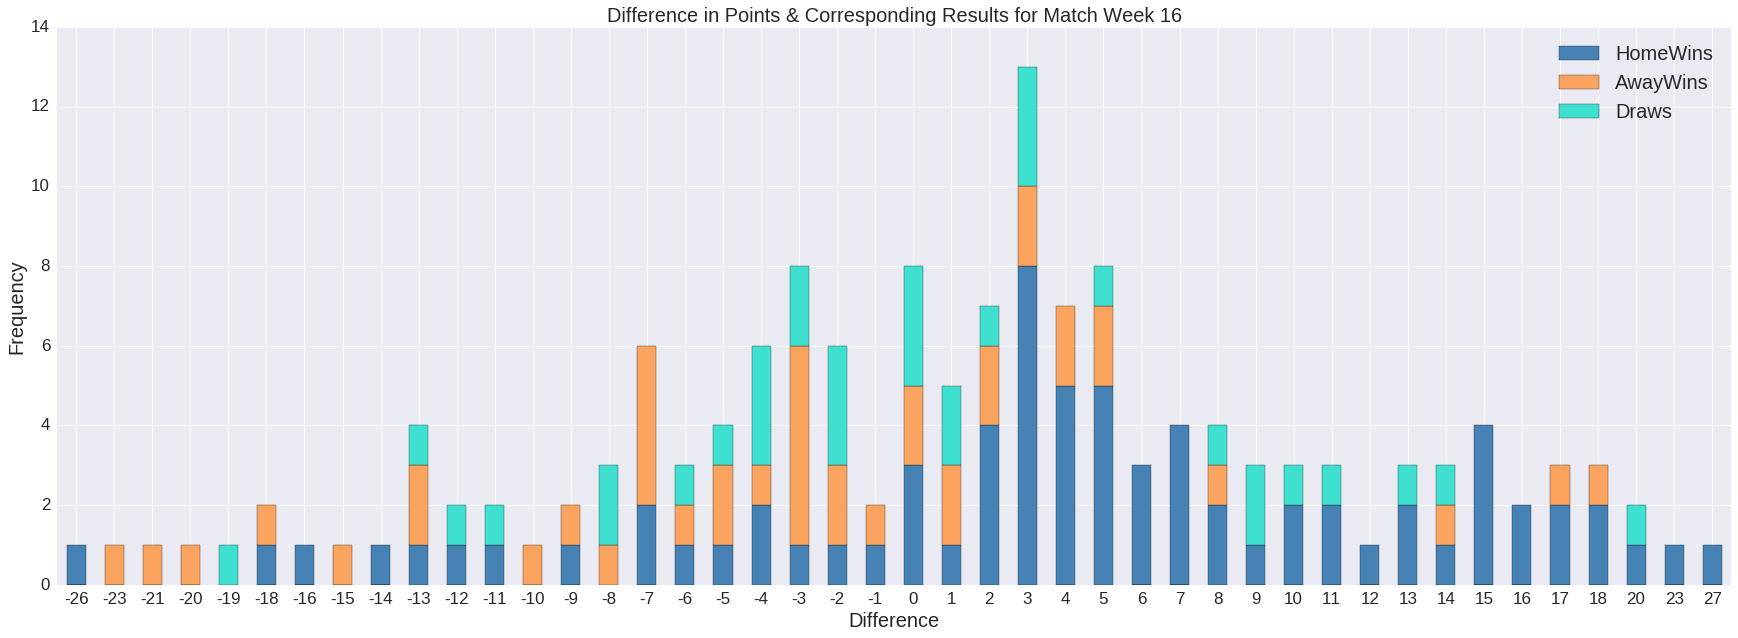

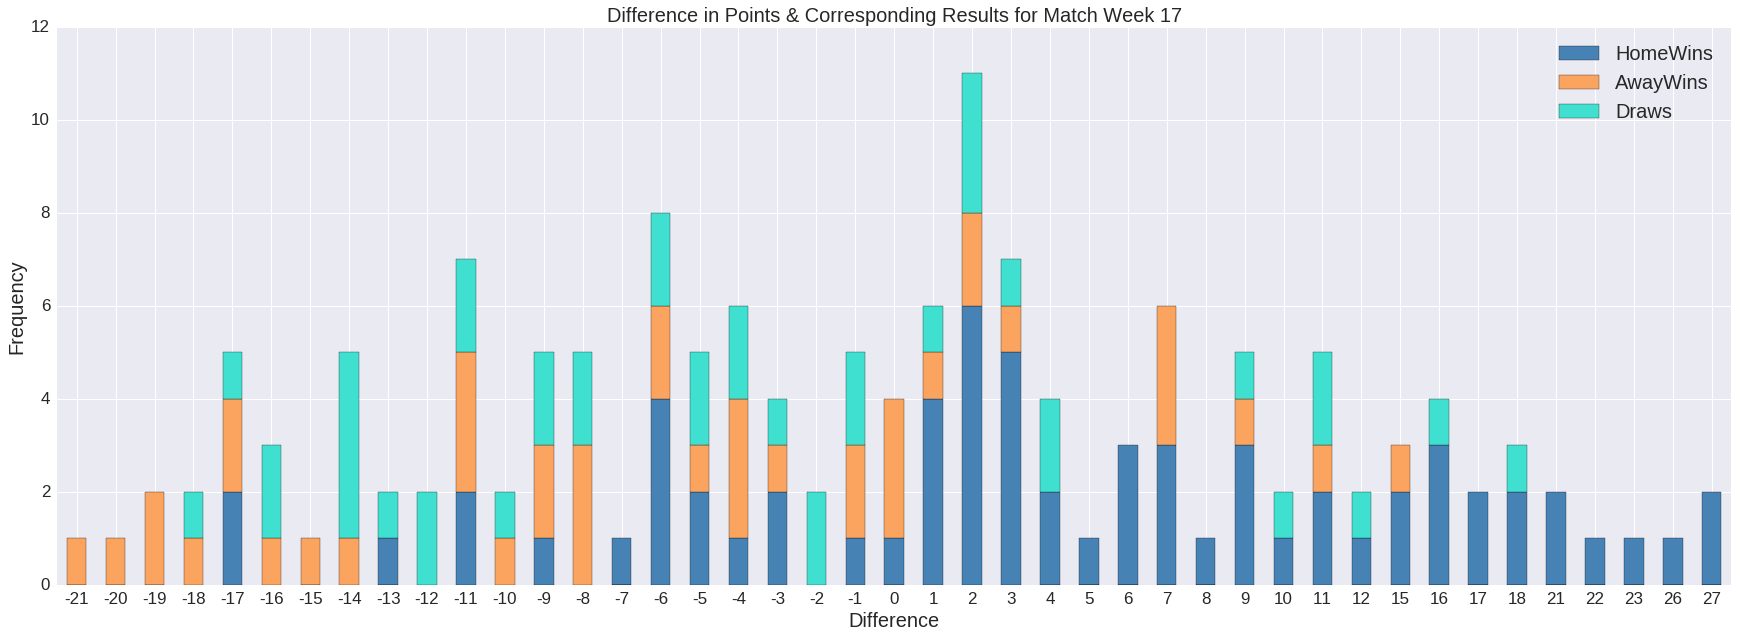

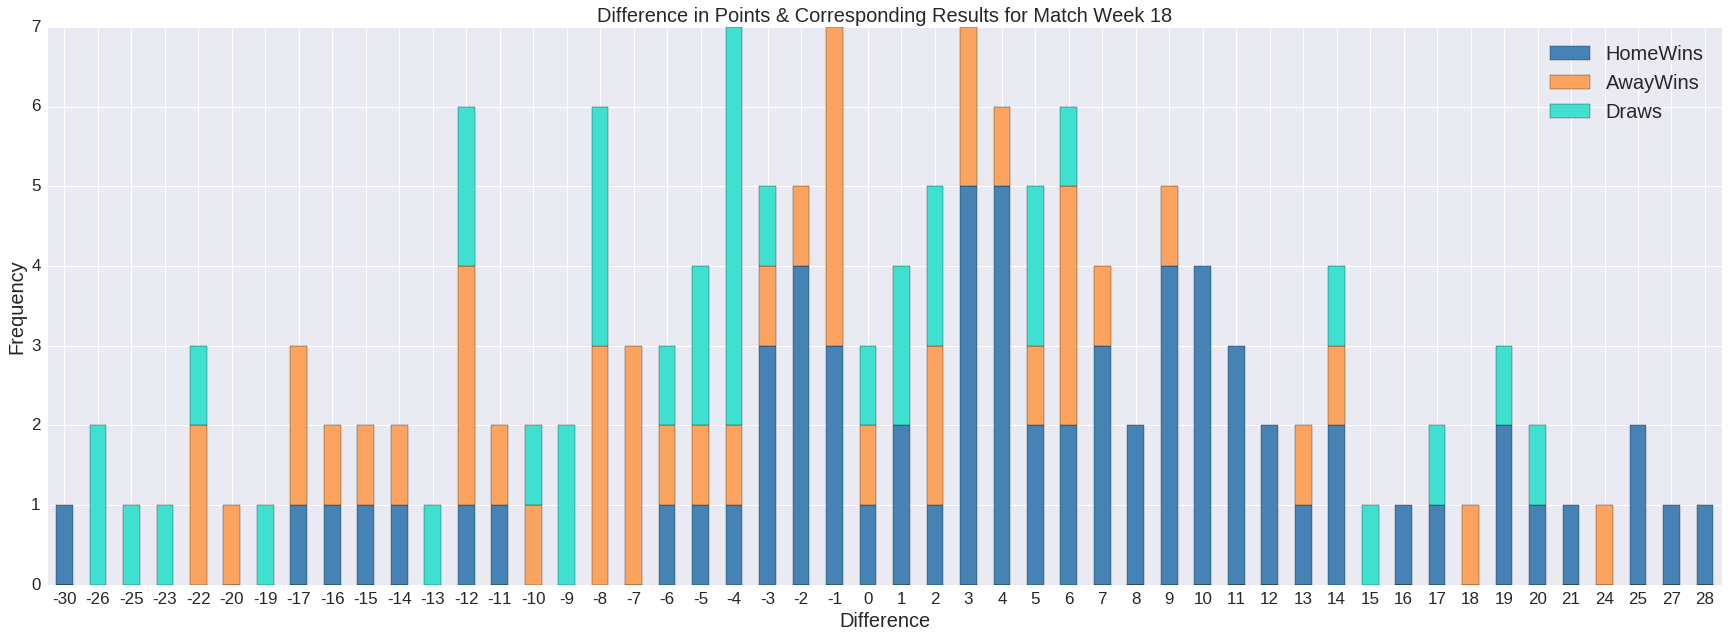

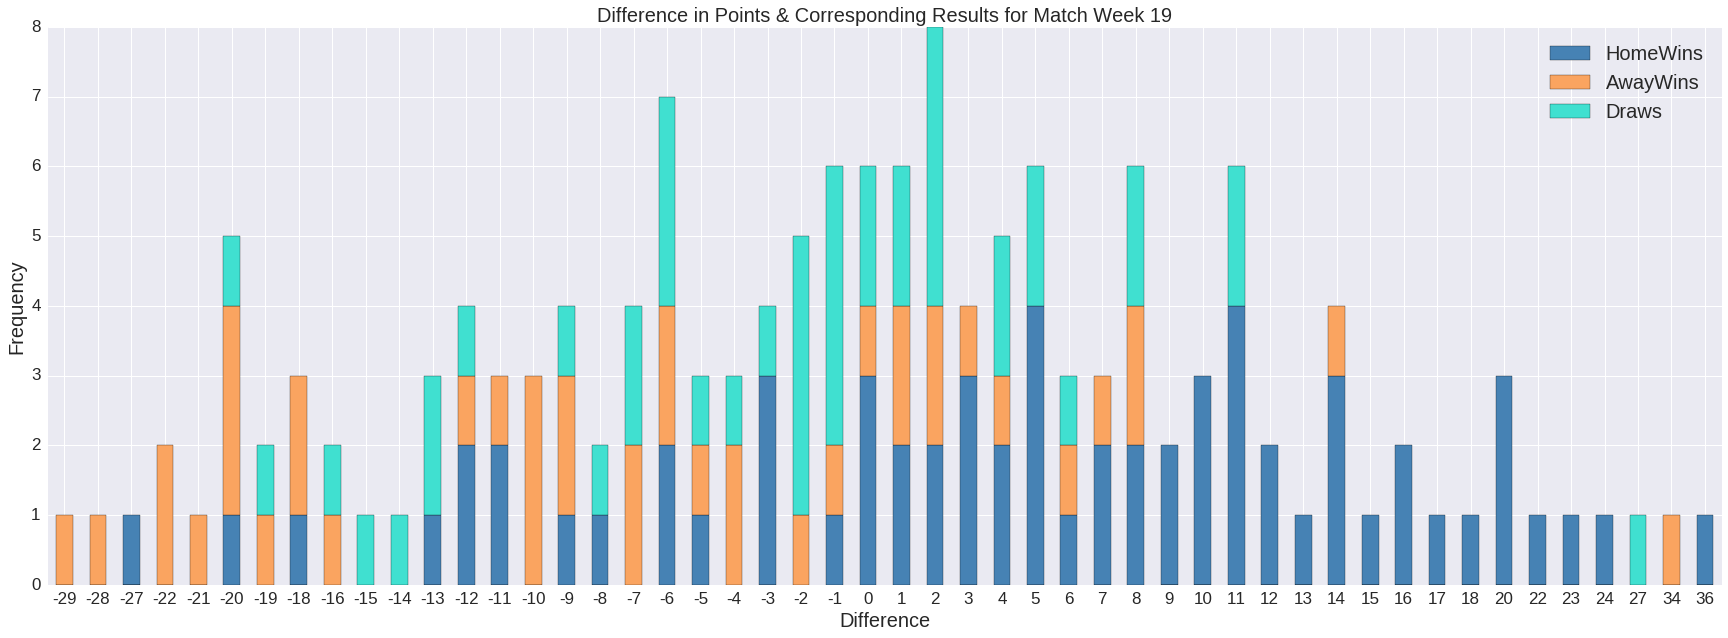

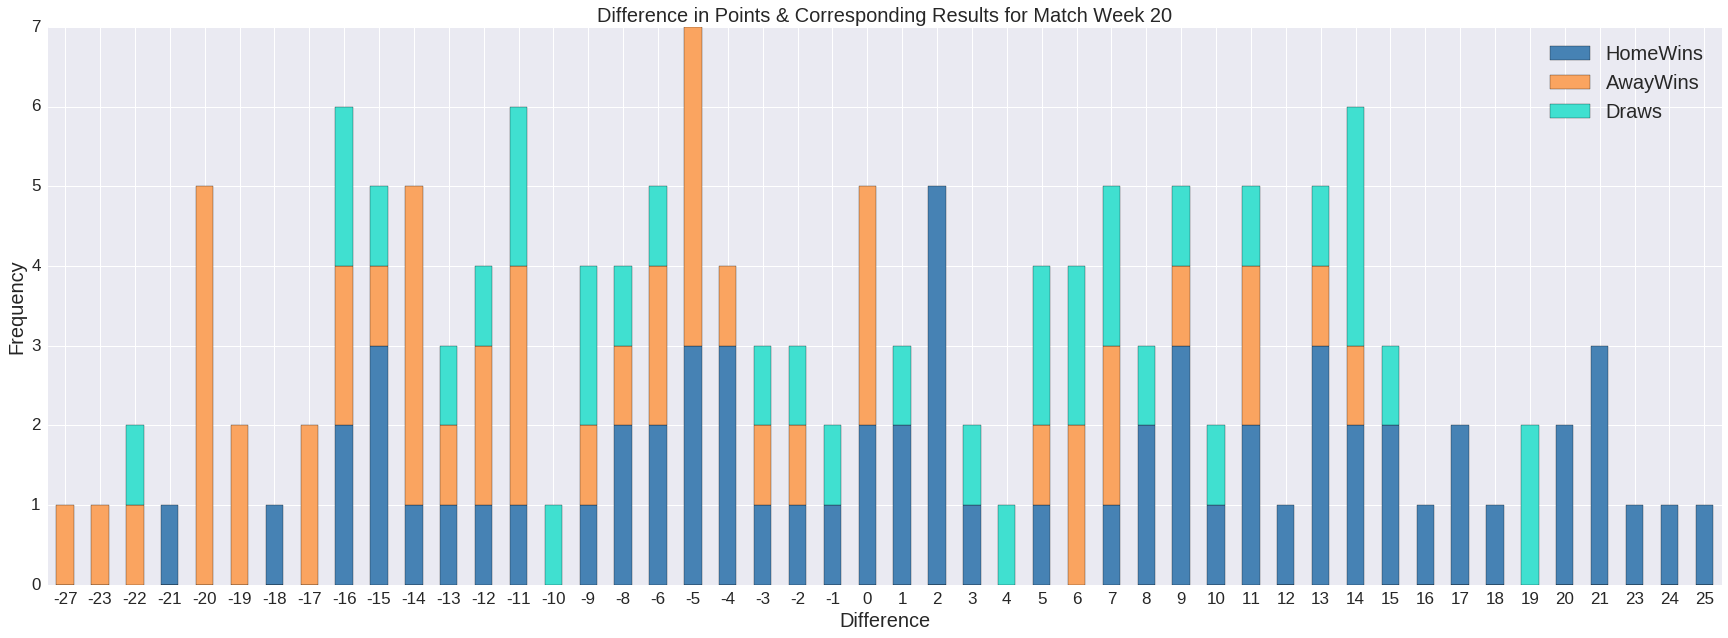

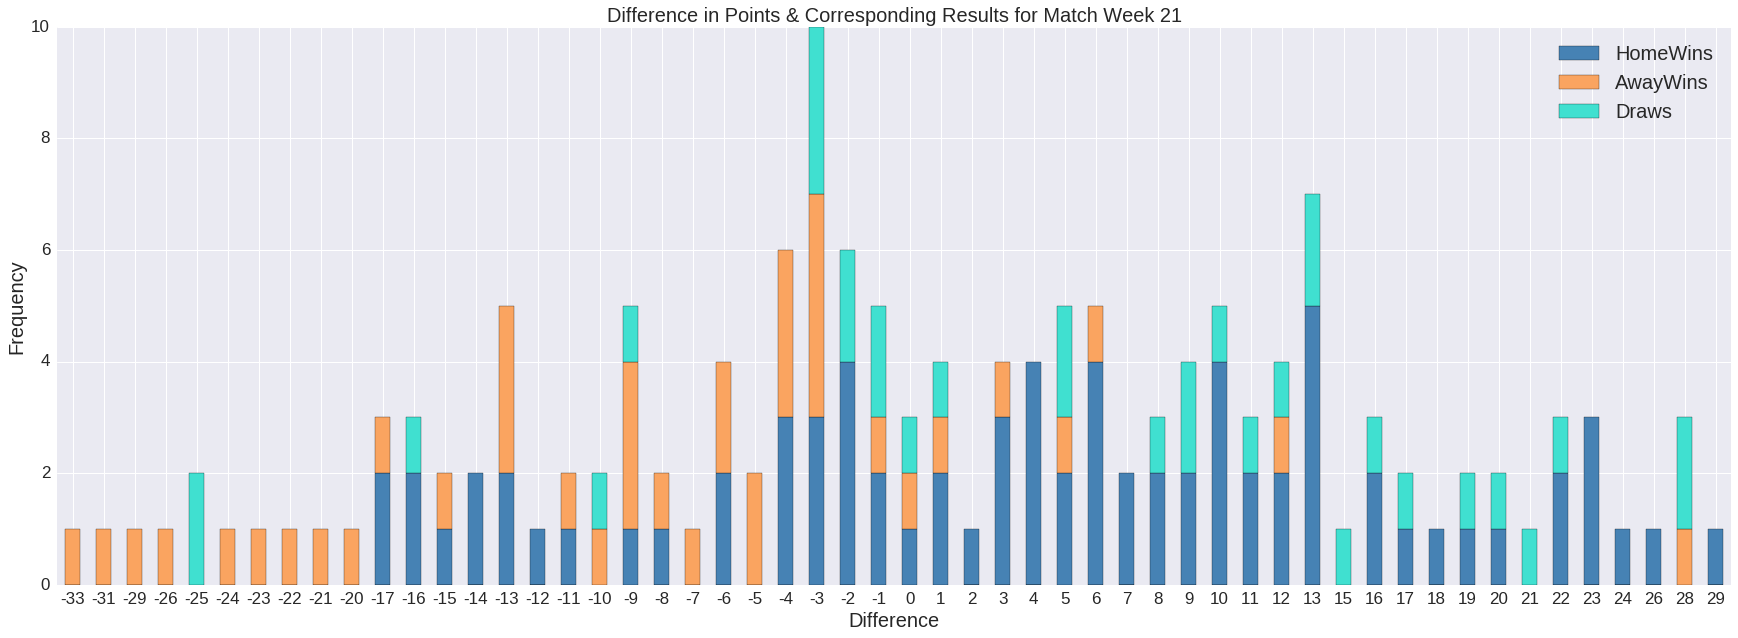

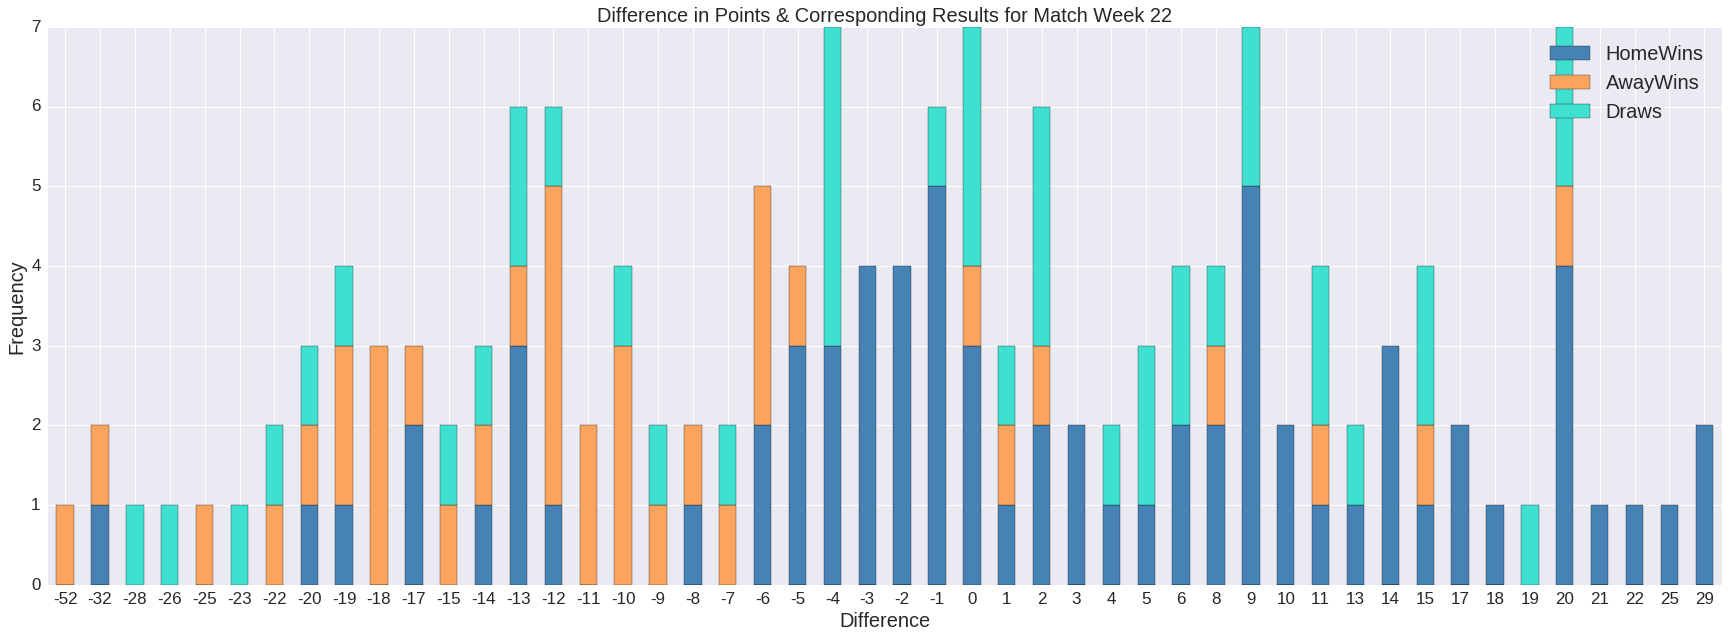

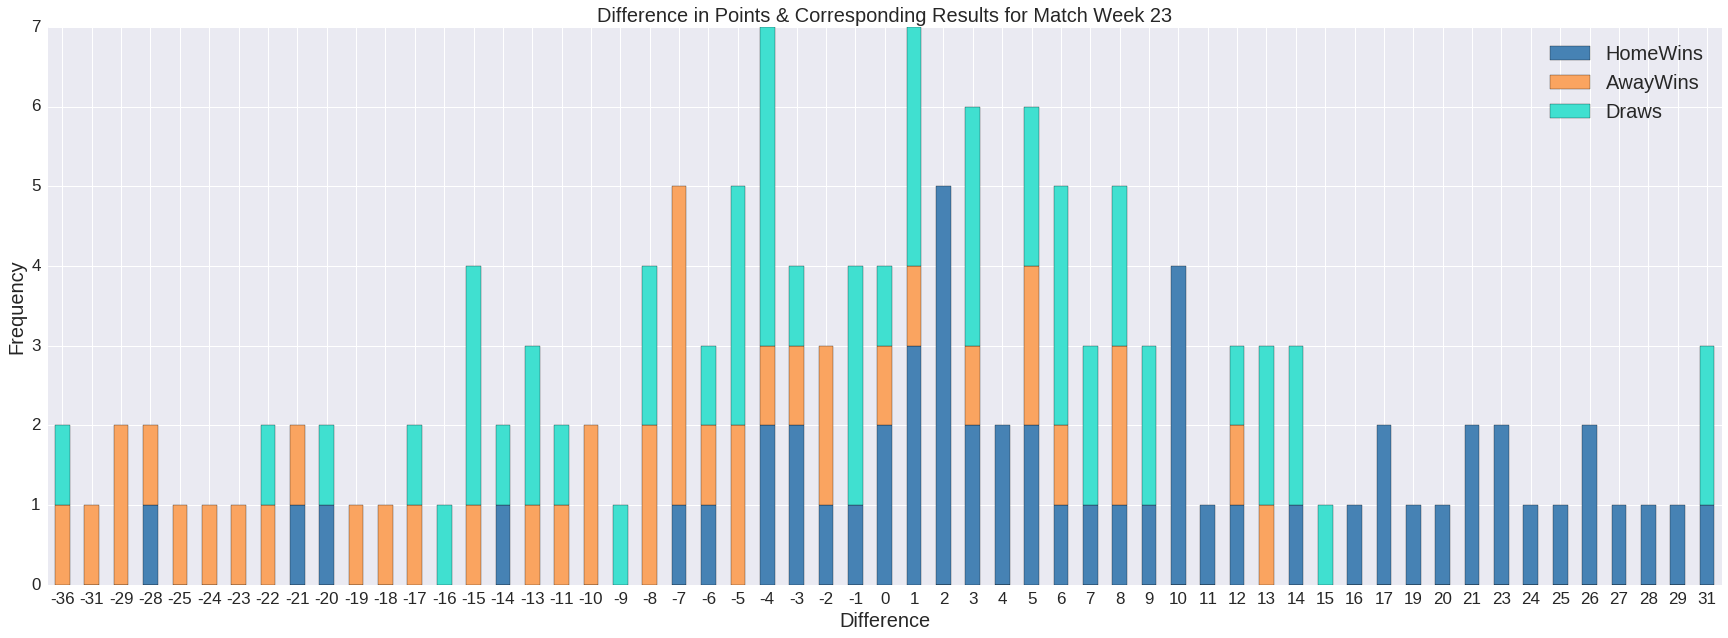

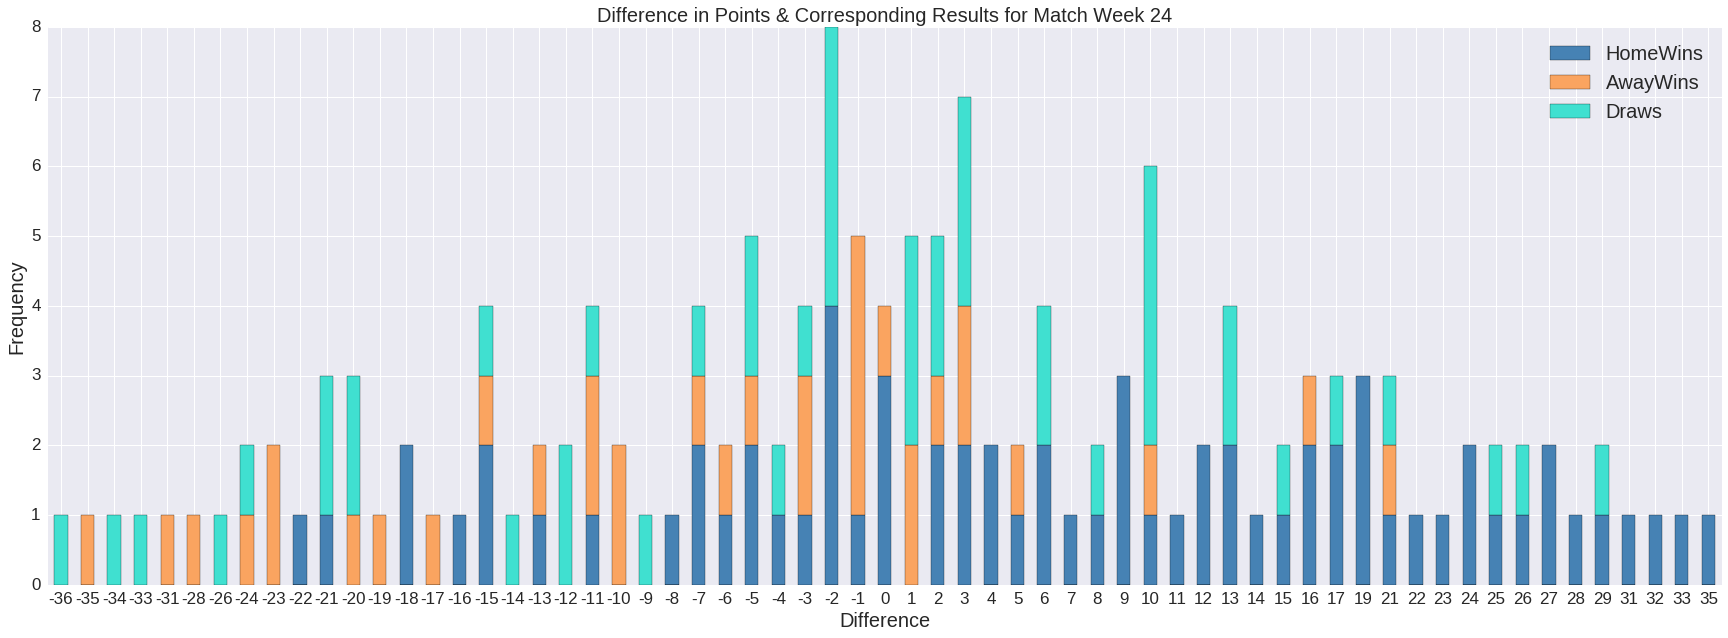

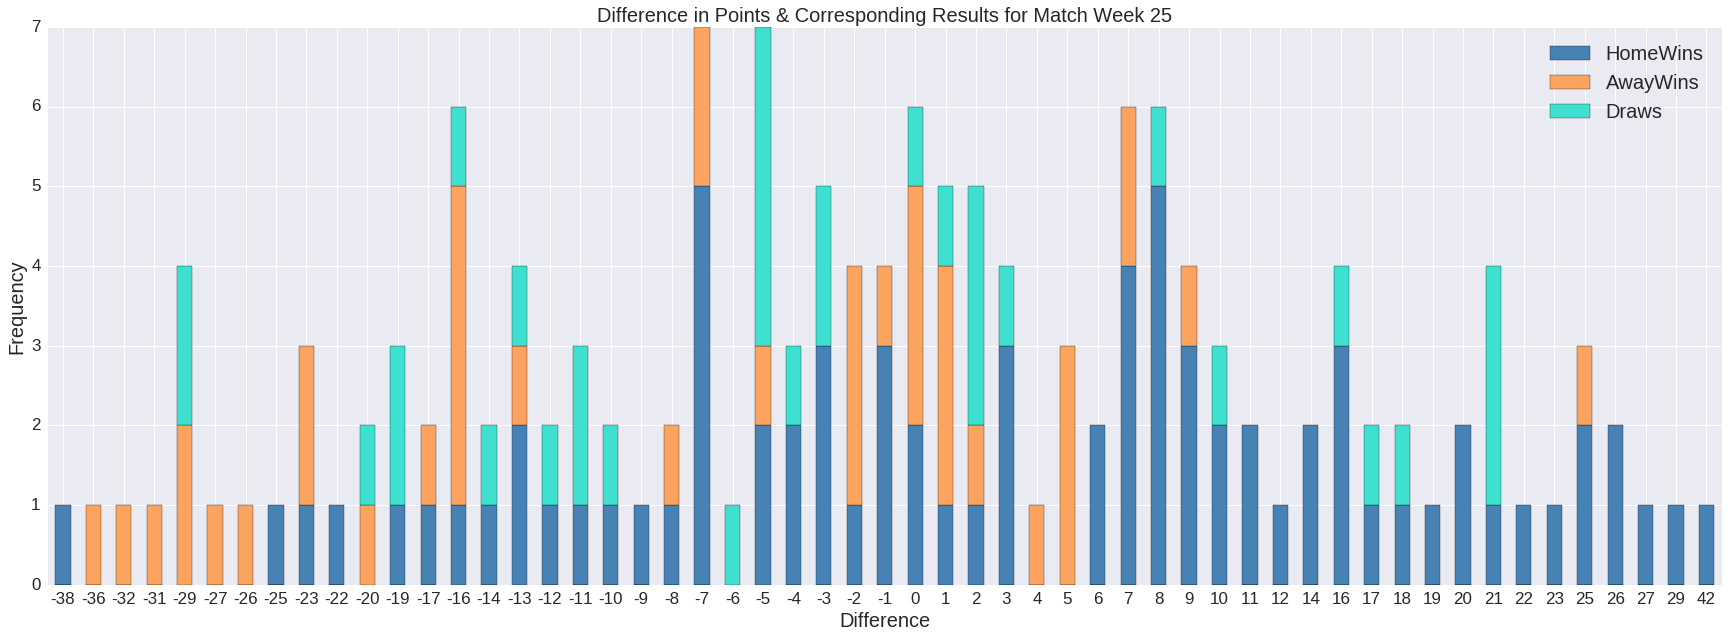

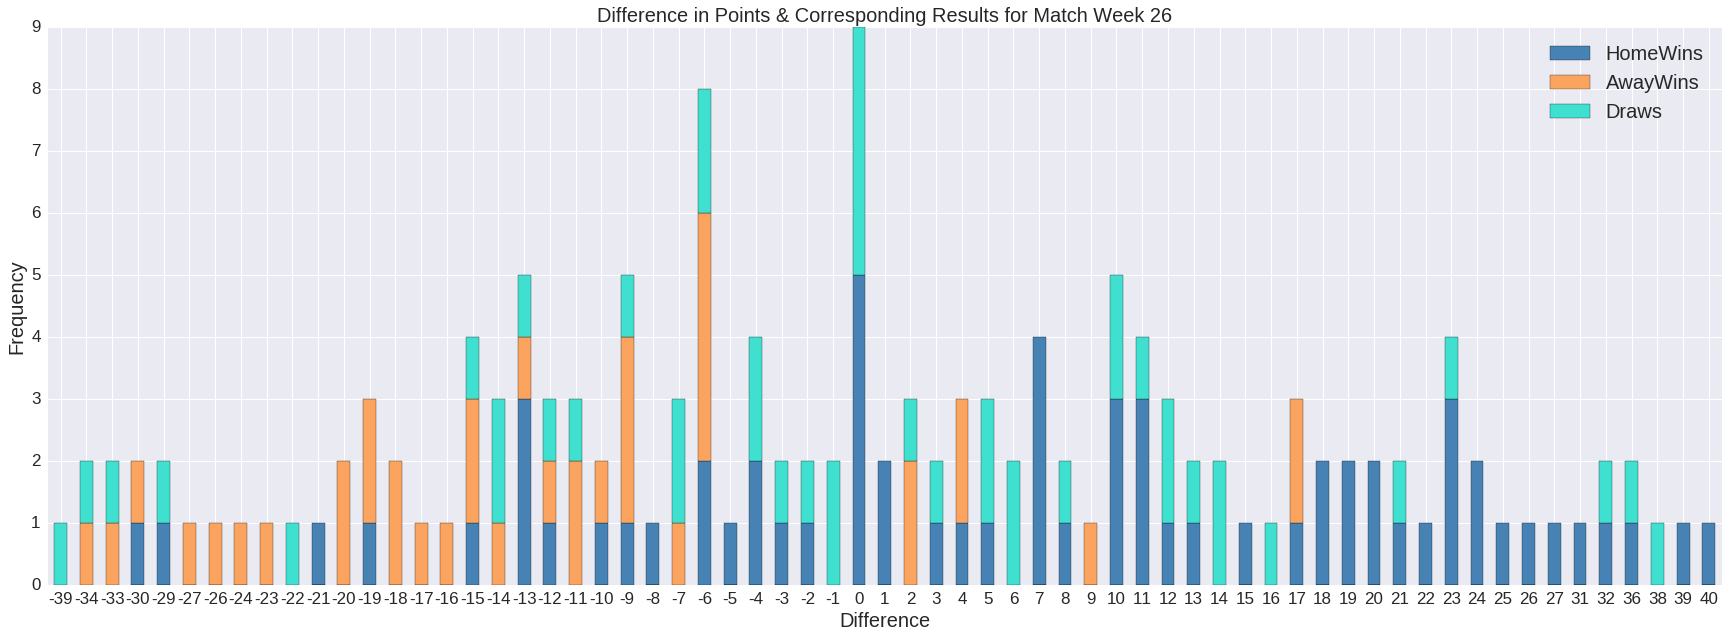

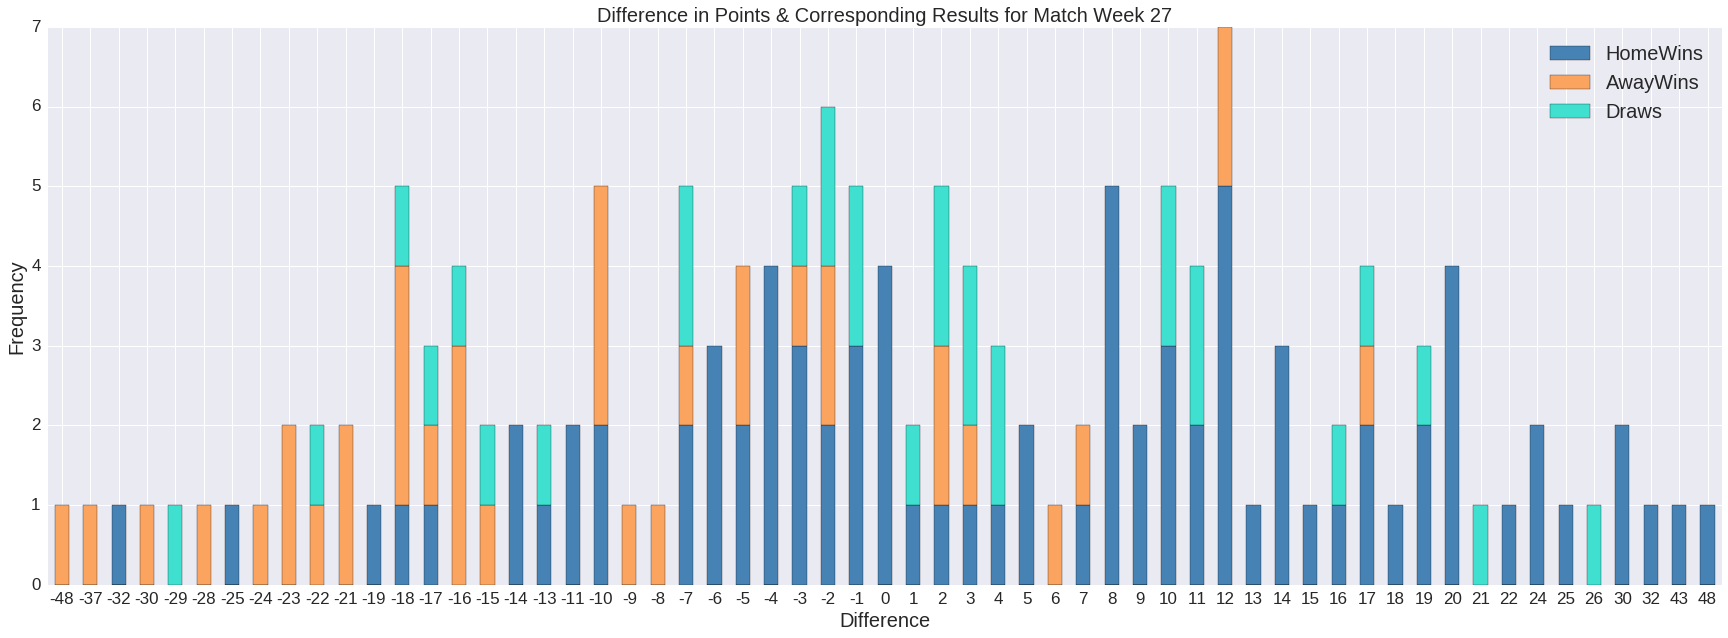

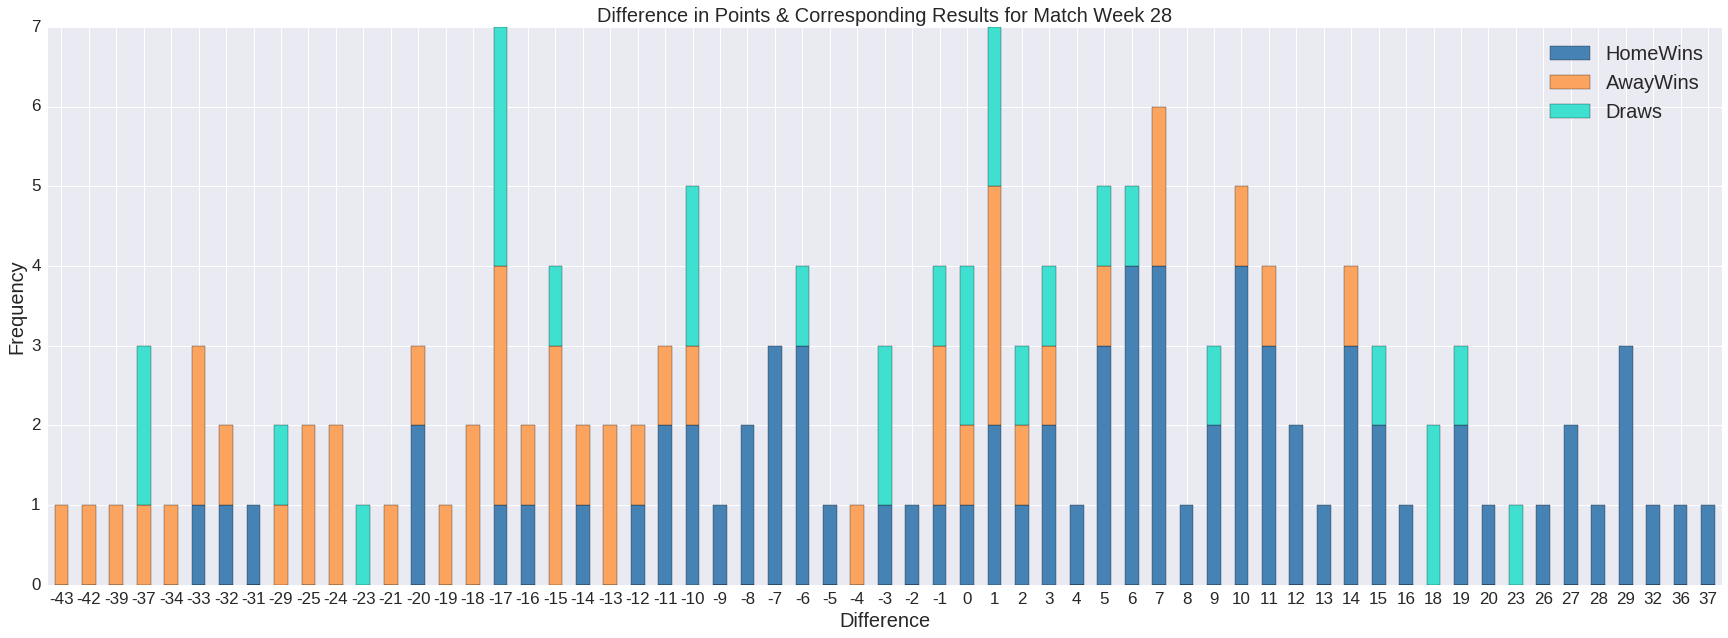

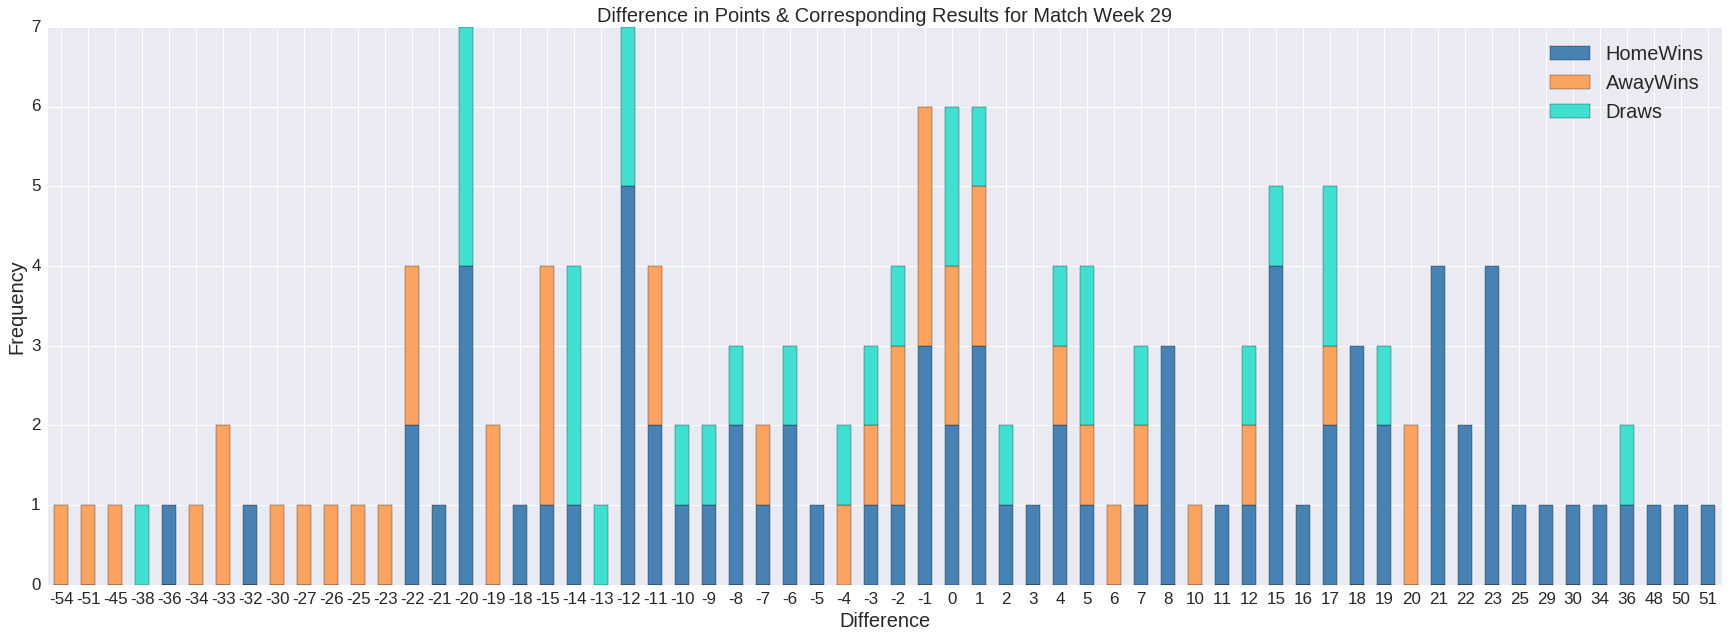

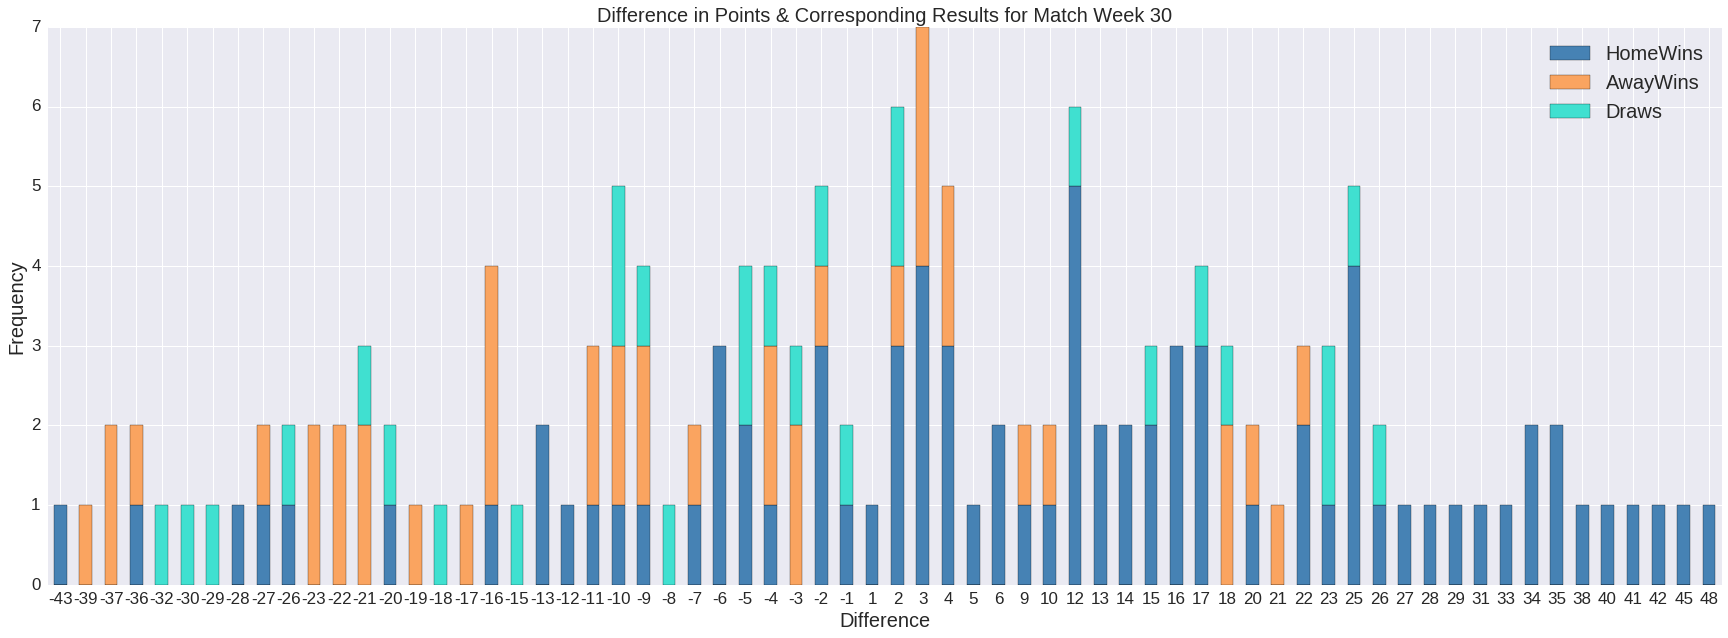

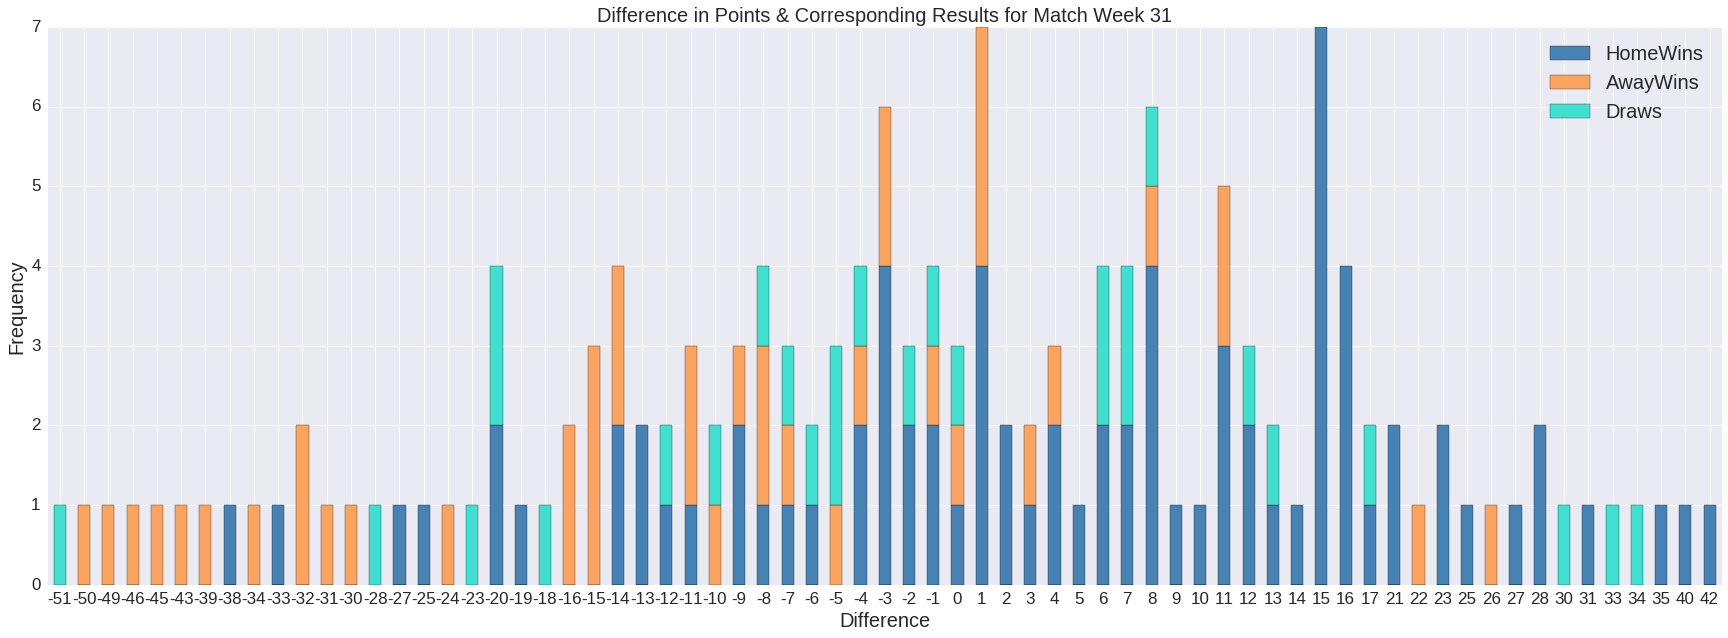

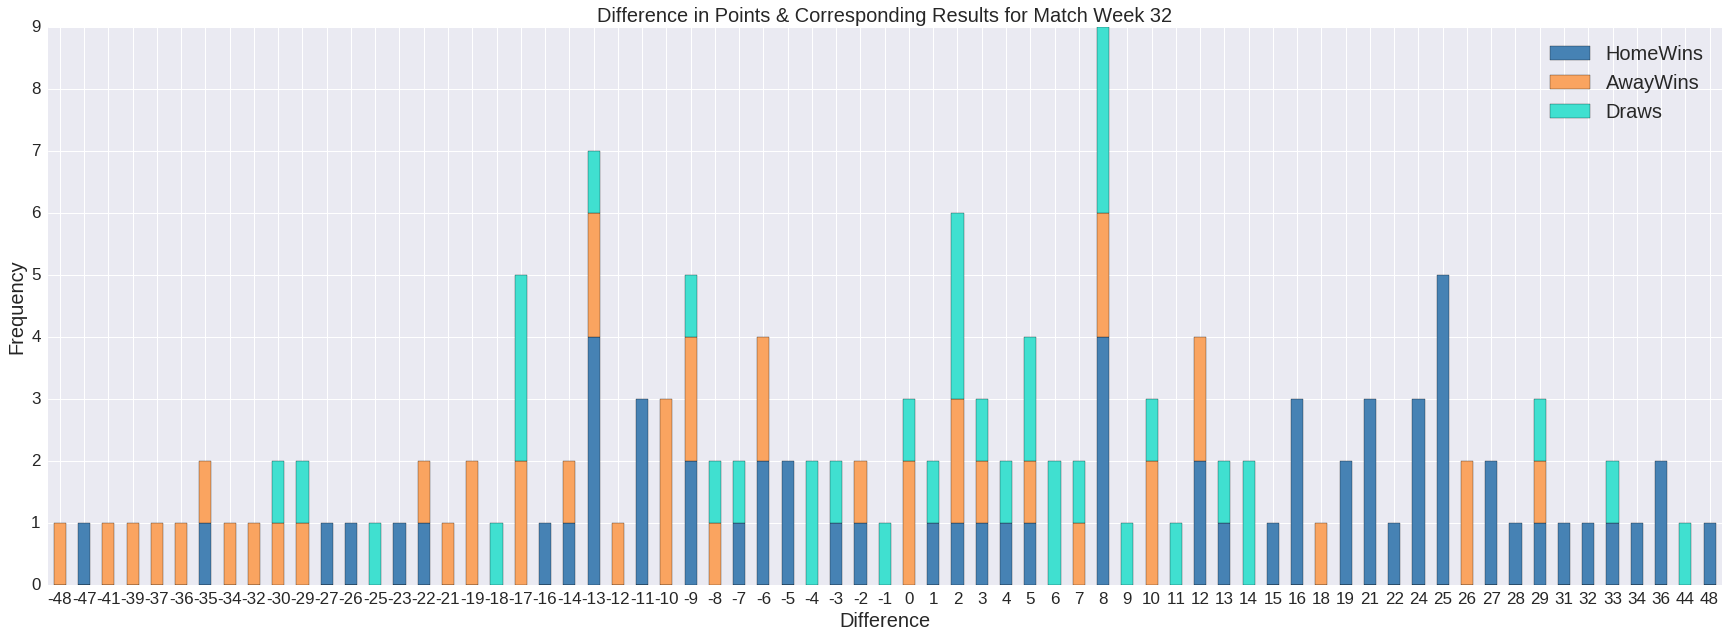

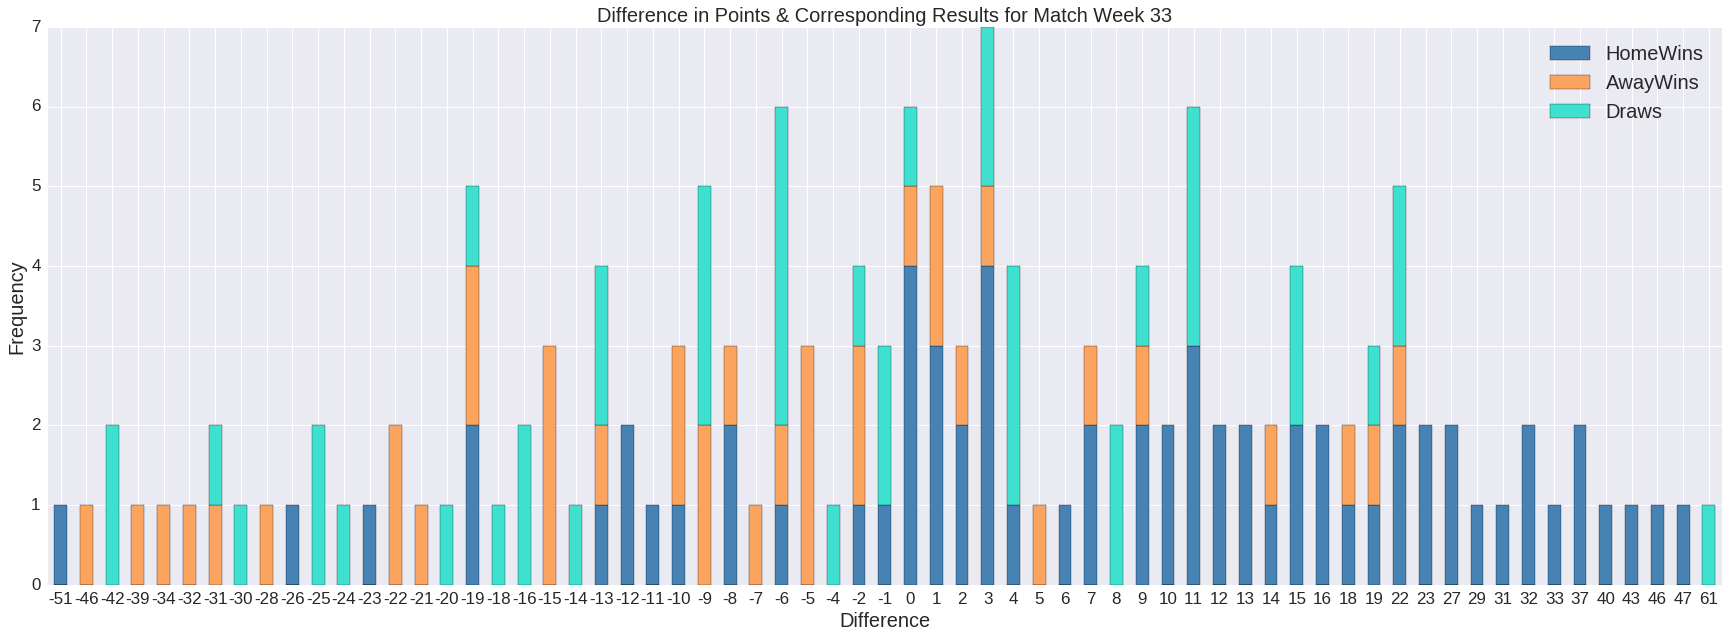

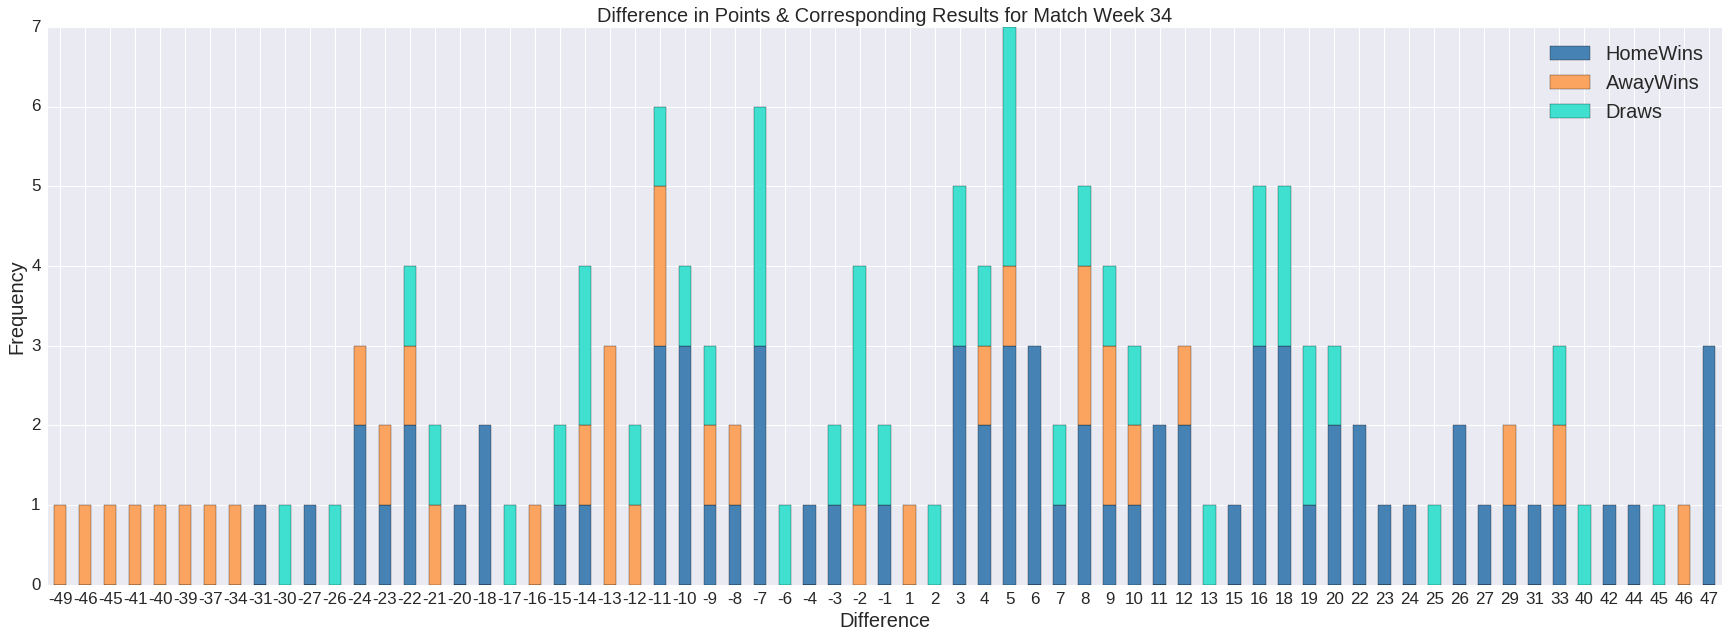

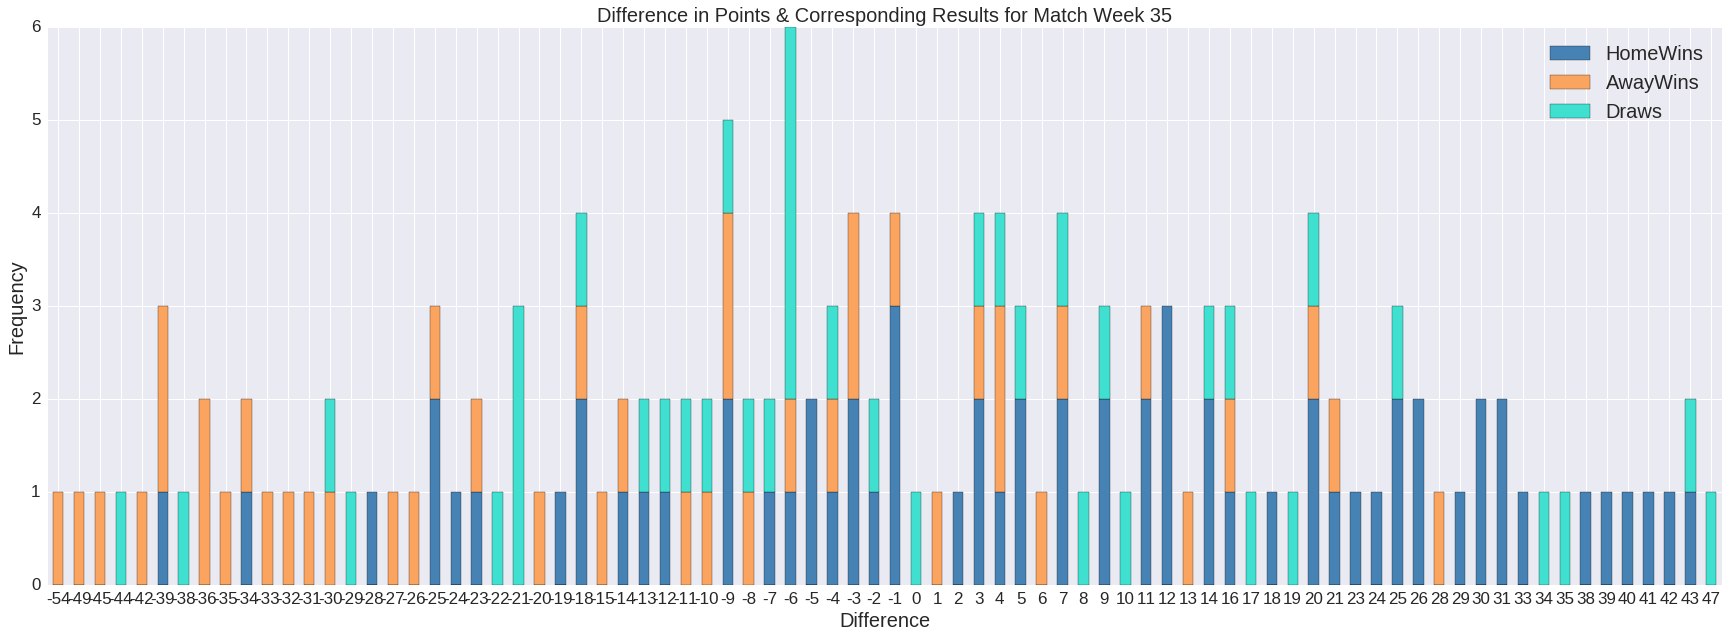

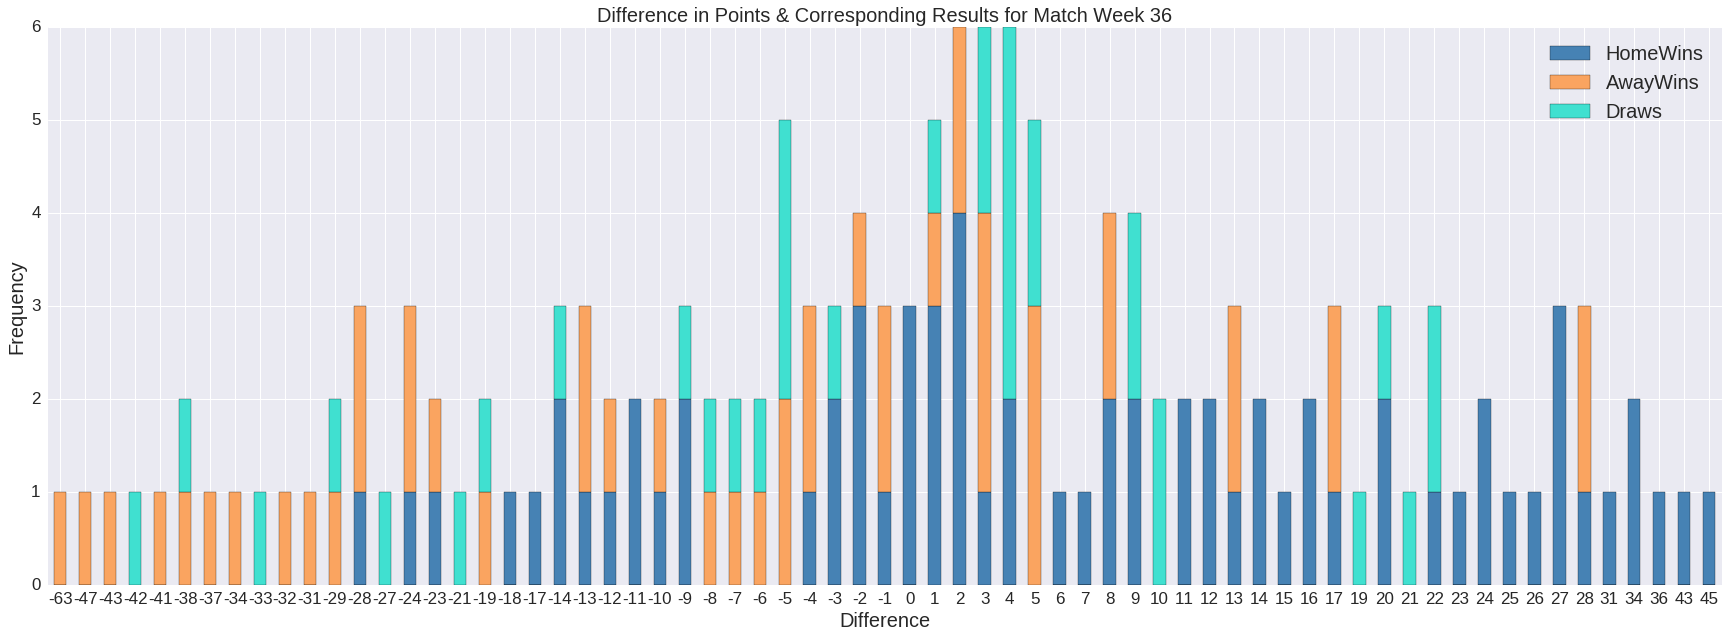

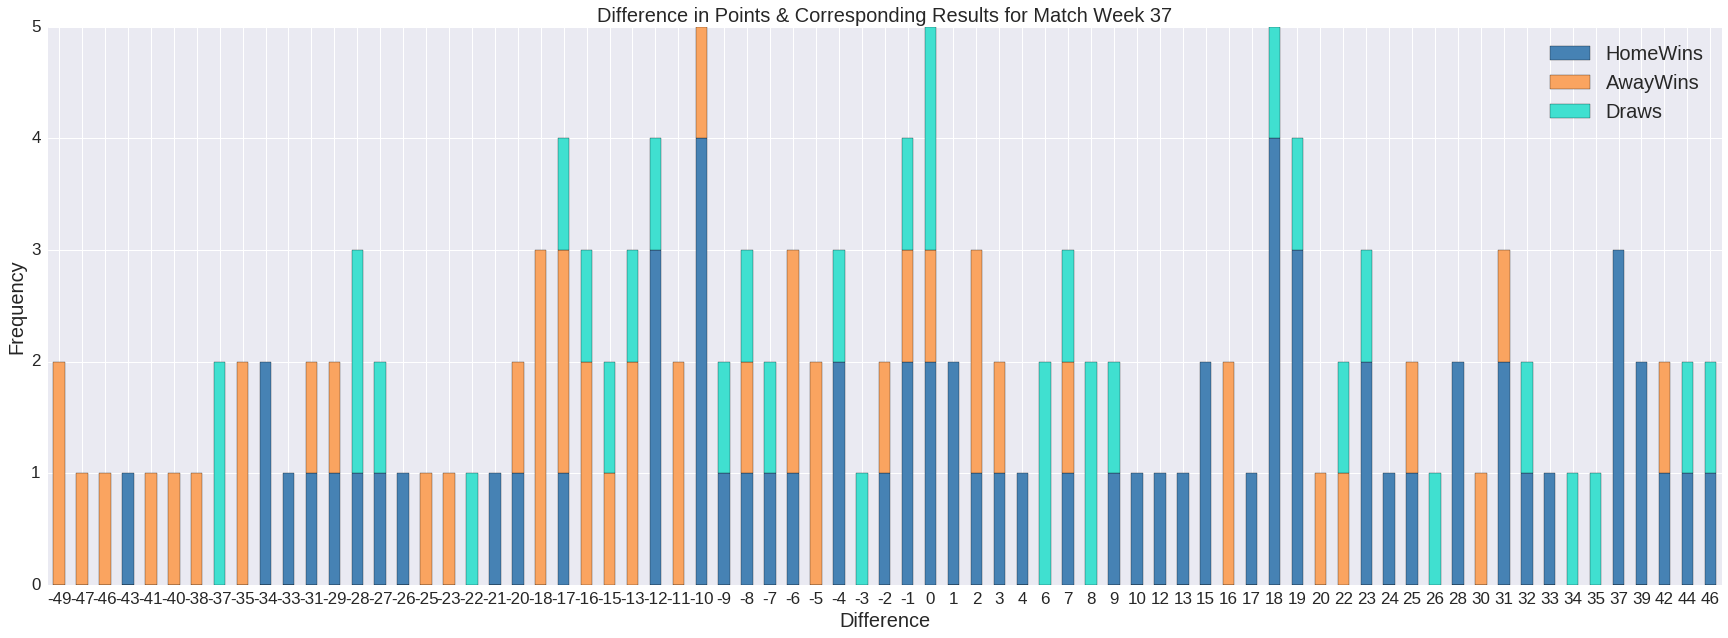

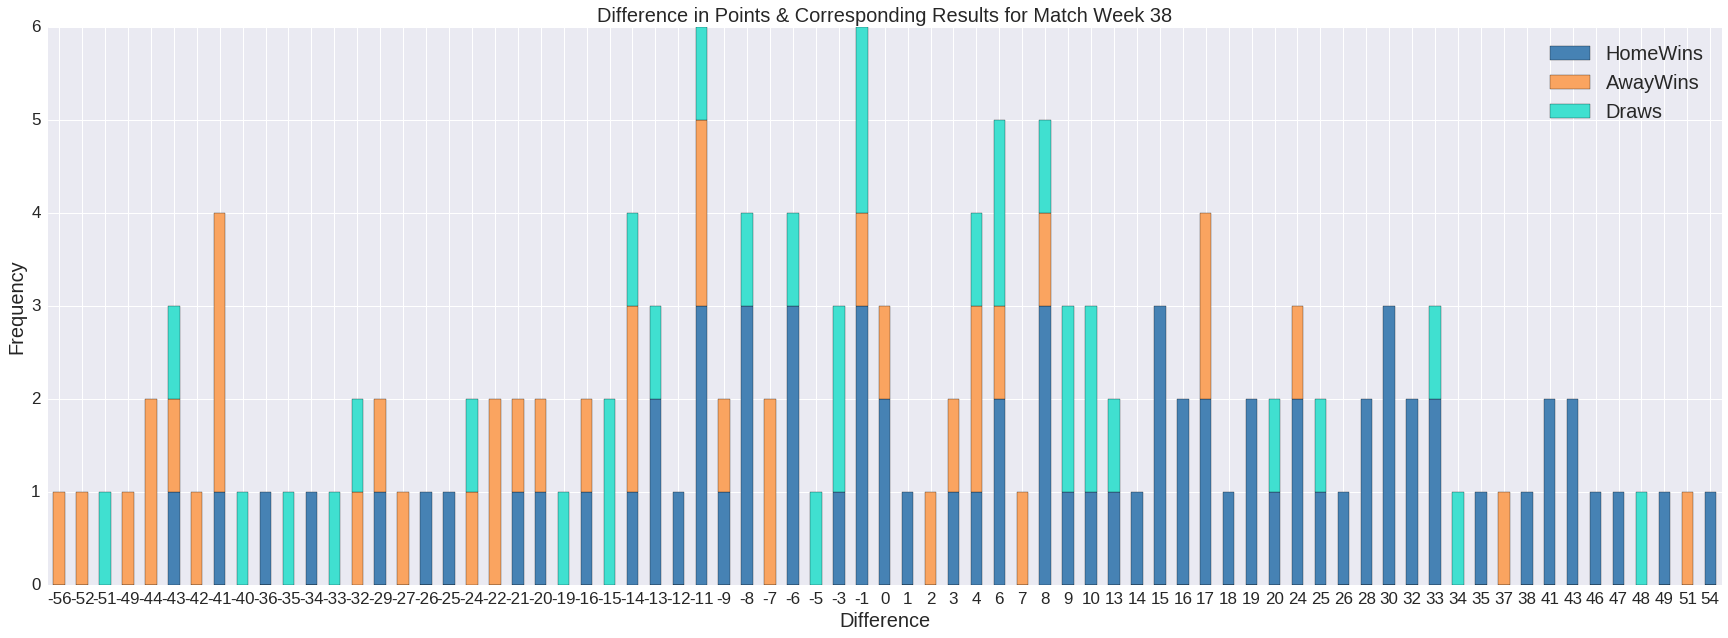

In [ ]:
for i in range(1,39):
    df = pd.DataFrame(mw_dist[i], index=['HomeWins', 'AwayWins', 'Draws'])
    
    #Plotting above dataframe
    df.T.plot(kind='bar', stacked = True, figsize=[30,10], color = ['steelblue','sandybrown', 'turquoise'])
    plt.legend(loc=1,prop={'size':20})
    plt.title('Difference in Points & Corresponding Results for Match Week ' + str(i), size = 20)
    plt.xlabel('Difference', size =20)
    plt.ylabel('Frequency', size =20)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.tick_params(axis='both', which='minor', labelsize=17)
    

col_df = list(mw_dist_38.columns)
range_df = abs(col_df[0]) + abs(col_df[-1])
size = 6

# Finds the lower limit of data which is divisibile by size
lcl = abs(col_df[0]) + abs(col_df[0] % size)
if col_df[0] < 0:
    lcl = -lcl

# Finds the upper limit
ucl =   col_df[-1] + (col_df[-1] % size)

# Generates ideal columns for dataframe
cols = [i for i in range(lcl,0)] + [i for i in range(ucl+1)]
cols

# Fills in for missing columns of dataframe
for col in cols:
    if col not in col_df:
        mw_dist_38[col] = [0,0,0]

# Sorts the column in ascending order and gets column which are divisible by size
mw_dist_38.sort(axis=1,ascending=True, inplace=True)
cols_sizew = [i for i in cols if i % size == 0 ]


# Creates  new df and assigns value to it
mw_dist_new = pd.DataFrame()

# Groups columns 
for col in cols_sizew:
    if col < 0:
        mw_dist_new[col] = (mw_dist_38[col] + mw_dist_38[col+1] + mw_dist_38[col+2] + mw_dist_38[col+3] + 
                            mw_dist_38[col+4] + mw_dist_38[col+5])
    elif col == 0:
        mw_dist_new[col] = mw_dist_38[col]
    else:
        mw_dist_new[col] = (mw_dist_38[col] + mw_dist_38[col-1] + mw_dist_38[col-2] + mw_dist_38[col-3] + 
                            mw_dist_38[col-4] + mw_dist_38[col-5])


mw_dist_new.T.plot(kind='bar', stacked = True, figsize=[30,10], color = ['steelblue','sandybrown', 'turquoise'])

mw_dist_38.rename(columns = {0:'HomeWins', 1:'AwayWins', 2:'Draws', 3:'TotalMatches'}, inplace =True)
mw_dist_38.plot(kind='bar', stacked = True, figsize=[30,10], color = ['steelblue','sandybrown', 'turquoise'])

df = mw_dist_38.T


# 4) How does past head to head affect probablity of winning:

In [ ]:
# Creates a dictionary with team names as keys and another dictionary as values. The subsequent dictionary has all the
# opposition teams for that particular team as keys and en empty list as its values.

def get_h2h_dict(playing_stat):
    teams = set(playing_stat.HomeTeam)
    head_to_head = {}
    
    for team in teams:
        for opp in teams:
            if team != opp:                             # Since a team can't play against itself
                if team not in head_to_head:            # Adds only if the team hasn't already been added
                    head_to_head[team] = {opp:[]}
                else:
                    if opp not in head_to_head[team]:   # Ensures one opposition is only added once.
                        head_to_head[team][opp] = []
    return head_to_head, teams


In [ ]:
# Gets the head to head results for all teams in a given year

def get_h2h_stat(playing_stat):
    h2h, teams = get_h2h_dict(playing_stat)
    for team in h2h:
        for i in range(380):
            ht = playing_stat.iloc[i].HomeTeam
            at = playing_stat.iloc[i].AwayTeam
            res = playing_stat.iloc[i].FTR
            if ht == team:
                if res == 'H':
                    h2h[team][at].append(['H', 'W'])
                elif res == 'A':
                    h2h[team][at].append(['H', 'L'])
                else:
                    h2h[team][at].append(['H', 'D'])
        
            elif at == team:
                if res == 'H':
                    h2h[team][ht].append(['A', 'L'])
                elif res == 'A':
                    h2h[team][ht].append(['A', 'W'])
                else:
                    h2h[team][ht].append(['A', 'D'])
    return h2h, teams

# Applies the above function to playing statistics of year 2011, 12 , 13 and 14.

h2h_9, teams9 = get_h2h_stat(playing_statistics_1)
h2h_10, teams10 = get_h2h_stat(playing_statistics_2)


In [ ]:
# Get only those teams which are present in each year:
comm_teams = teams9 & teams10 
print comm_teams

# Function to remove uncommon teams from head to head dict.
def remove_uncomm_teams(h2h, teams, comm_teams):
    teams_to_remove = set(teams) - comm_teams
    teams = set(teams)
    print teams_to_remove
    
    # Removes entire records of teams which are not there in all years
    for team in teams_to_remove:
        h2h.pop(team)
    
    # Removes record of teams which aren't there in all years from records of teams which are there
    for team in (teams-teams_to_remove):
        for opp in teams_to_remove:
            h2h[team].pop(opp)
    return h2h




set(['Southampton', 'Liverpool', 'West Ham', 'Man City', 'Leicester', 'Burnley', 'Arsenal', 'Bournemouth', 'Crystal Palace', 'Watford', 'Newcastle', 'Everton', 'Wolves', 'Man United', 'Chelsea', 'Tottenham', 'Brighton'])


In [ ]:
def merge_dicts(dicts_to_merge):
    new_dict = dicts_to_merge[0]
    for s_dict in dicts_to_merge[1:]:
        for key in dicts_to_merge[0].keys():
            for team in dicts_to_merge[0][key].keys():
                new_dict[key][team] = new_dict[key][team] + s_dict[key][team]
    return new_dict

h2h_agg = merge_dicts([h2hc_9, h2hc_10])

In [ ]:
def get_h2h_record(h2h_agg):
    h2h_stat = {}
    teams = set(h2h_agg.keys())
    
    # Creates a dict with team names as keys and another dict of teams as values.
    for team in teams:
        h2h_stat[team] = {}
        
        for opp in teams:
            if opp != teams:
                h2h_stat[team][opp] = []
    
    # Loops through all the teams    
    for team in teams:
        other_teams = teams - set([team])
        
        for opp in other_teams:
            results = h2h_agg[team][opp]
            
            #Looping through the results
            h_wins = 0
            h_losses = 0
            h_draws = 0
            awh_wins = 0
            awh_losses = 0
            awh_draws = 0
            total = len(results)
            for result in results:
                side = result[0]
                res = result[1]
                if side == 'H':
                    if res == 'W':
                        h_wins += 1
                    elif res == 'L':
                        h_losses += 1
                    else:
                        h_draws += 1
                if side == 'A':
                    if res == 'W':
                        awh_wins += 1
                    elif res == 'L':
                        awh_losses += 1
                    else:
                        awh_draws += 1
            h2h_stat[team][opp] = {(team +' Home Wins'):h_wins,('Home Losses'): h_losses, 'Home Draws':h_draws, 
                                   (team + ' Away Wins'):awh_wins,'Away Losses':awh_losses,'Away Draws':awh_draws,
                                   'Total Matches':total}
    return h2h_stat
                
        
h2h_stats = get_h2h_record(h2h_agg)

In [ ]:
# This function merges the past head to head record with the year required's result and returns a dataframe.

def getall_h2h_record(h2h_stats, team, h2hc, year_of_h2hc):
    teams = set(h2h_stats.keys()) - set([team])
    df_dict = {}
    for some_team in teams:
        stat = h2h_stats[team][some_team]
        res = h2hc[team][some_team]
        stat[ res[0][0] ] = res[0][1]
        stat[ res[1][0] ] = res[1][1]
        df_dict[some_team] = stat
    df = pd.DataFrame(data=df_dict).T
    
    # Rename columns for h2hc_year
    df['Home Result of ' + year_of_h2hc] = df['H']
    df['Away Result of ' + year_of_h2hc] = df['A']
        
    # Reorder columns
    df.fillna(value= 'None')
    cols = [team +' Home Wins', 'Home Losses','Home Draws', 'Home Result of ' + year_of_h2hc, 
            team + ' Away Wins', 'Away Losses', 'Away Draws', 'Total Matches', 'Away Result of ' + year_of_h2hc]
    df = df[cols]
    return df

h2h14_arsenal = getall_h2h_record(h2h_stats, 'Arsenal', h2hc_9, '2019')
h2h14_mancity = getall_h2h_record(h2h_stats, 'Man City', h2hc_10, '2020')


In [ ]:
# Calculates the probability from the h2h record so obtained

def get_h2h_prob(h2h14, team, num_matches):
    cols = [team +' Home Wins', 'Home Losses', 'Home Draws', team + ' Away Wins', 'Away Losses', 'Away Draws']
    h2h14.drop('Total Matches', axis=1, inplace=True)
    for column in cols:
        h2h14[column] = h2h14[column] / (num_matches/2)
    return h2h14

get_h2h_prob(h2h14_mancity, 'Man City', 10)

Man City Home Wins Home Losses Home Draws Home Result of 2020  \
Arsenal                       0.4           0          0                   W   
Bournemouth                   0.4           0          0                   W   
Brighton                      0.4           0          0                   W   
Burnley                       0.4           0          0                   W   
Chelsea                       0.4           0          0                   W   
Crystal Palace                  0         0.2        0.2                   D   
Everton                       0.4           0          0                   W   
Leicester                     0.4           0          0                   W   
Liverpool                     0.4           0          0                   W   
Man United                    0.2         0.2          0                   L   
Newcastle                     0.4           0          0                   W   
Southampton                   0.4           0          0                   W   
Tottenham                     0.2           0        0.2                   D   
Watford                       0.4           0          0                   W   
West Ham                      0.4           0          0                   W   
Wolves                        0.2         0.2          0                   L   

               Man City Away Wins Away Losses Away Draws Away Result of 2020  
Arsenal                       0.4           0          0                   W  
Bournemouth                   0.4           0          0                   W  
Brighton                      0.4           0          0                   W  
Burnley                       0.4           0          0                   W  
Chelsea                         0         0.4          0                   L  
Crystal Palace                0.4           0          0                   W  
Everton                       0.4           0          0                   W  
Leicester                     0.2         0.2          0                   W  
Liverpool                       0         0.2        0.2                   L  
Man United                    0.2         0.2          0                   L  
Newcastle                       0         0.2        0.2                   D  
Southampton                   0.2         0.2          0                   L  
Tottenham                     0.2         0.2          0                   L  
Watford                       0.4           0          0                   W  
West Ham                      0.4           0          0                   W  
Wolves                          0         0.2        0.2                   L